In [3]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns

import utils
from config import store_dir, data_dir, date_key
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [4]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
hmdb_v4 = pd.read_csv(os.path.join(data_dir, 'databases/HMDB_v4.csv'), index_col=None).set_index('chemical_formula')
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [5]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=15)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

In [101]:
# adata = utils.make_ion_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)
adata = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)
adata.var = adata.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

100%|██████████| 7443/7443 [00:15<00:00, 473.91it/s]


11514  features


100%|██████████| 7443/7443 [00:44<00:00, 166.89it/s]
/home/trose/projects/metaspace_evaluation/utils.py:220: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mol_data.to_numpy(), var=pd.DataFrame(mol_features), obs=mdt.loc[mol_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [164]:
adata.var

n_cells
molecule             
C6H5ClO5         1221
C92H165N3O39      511
C17H16N2O4        468
C10H8F2O3         238
C18H22N2          308
...               ...
C30H24O14         320
C14H24O8          232
C20H21N3O3        315
C7H5NO2           495
C26H32O12         388

[6943 rows x 1 columns]

In [102]:
sc.pp.filter_genes(adata, min_cells=200)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.tl.pca(adata)
#sc.external.pp.bbknn(adata, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [103]:
adata

AnnData object with n_obs × n_vars = 6101 × 6943
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 0, 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

# UMAP

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data f

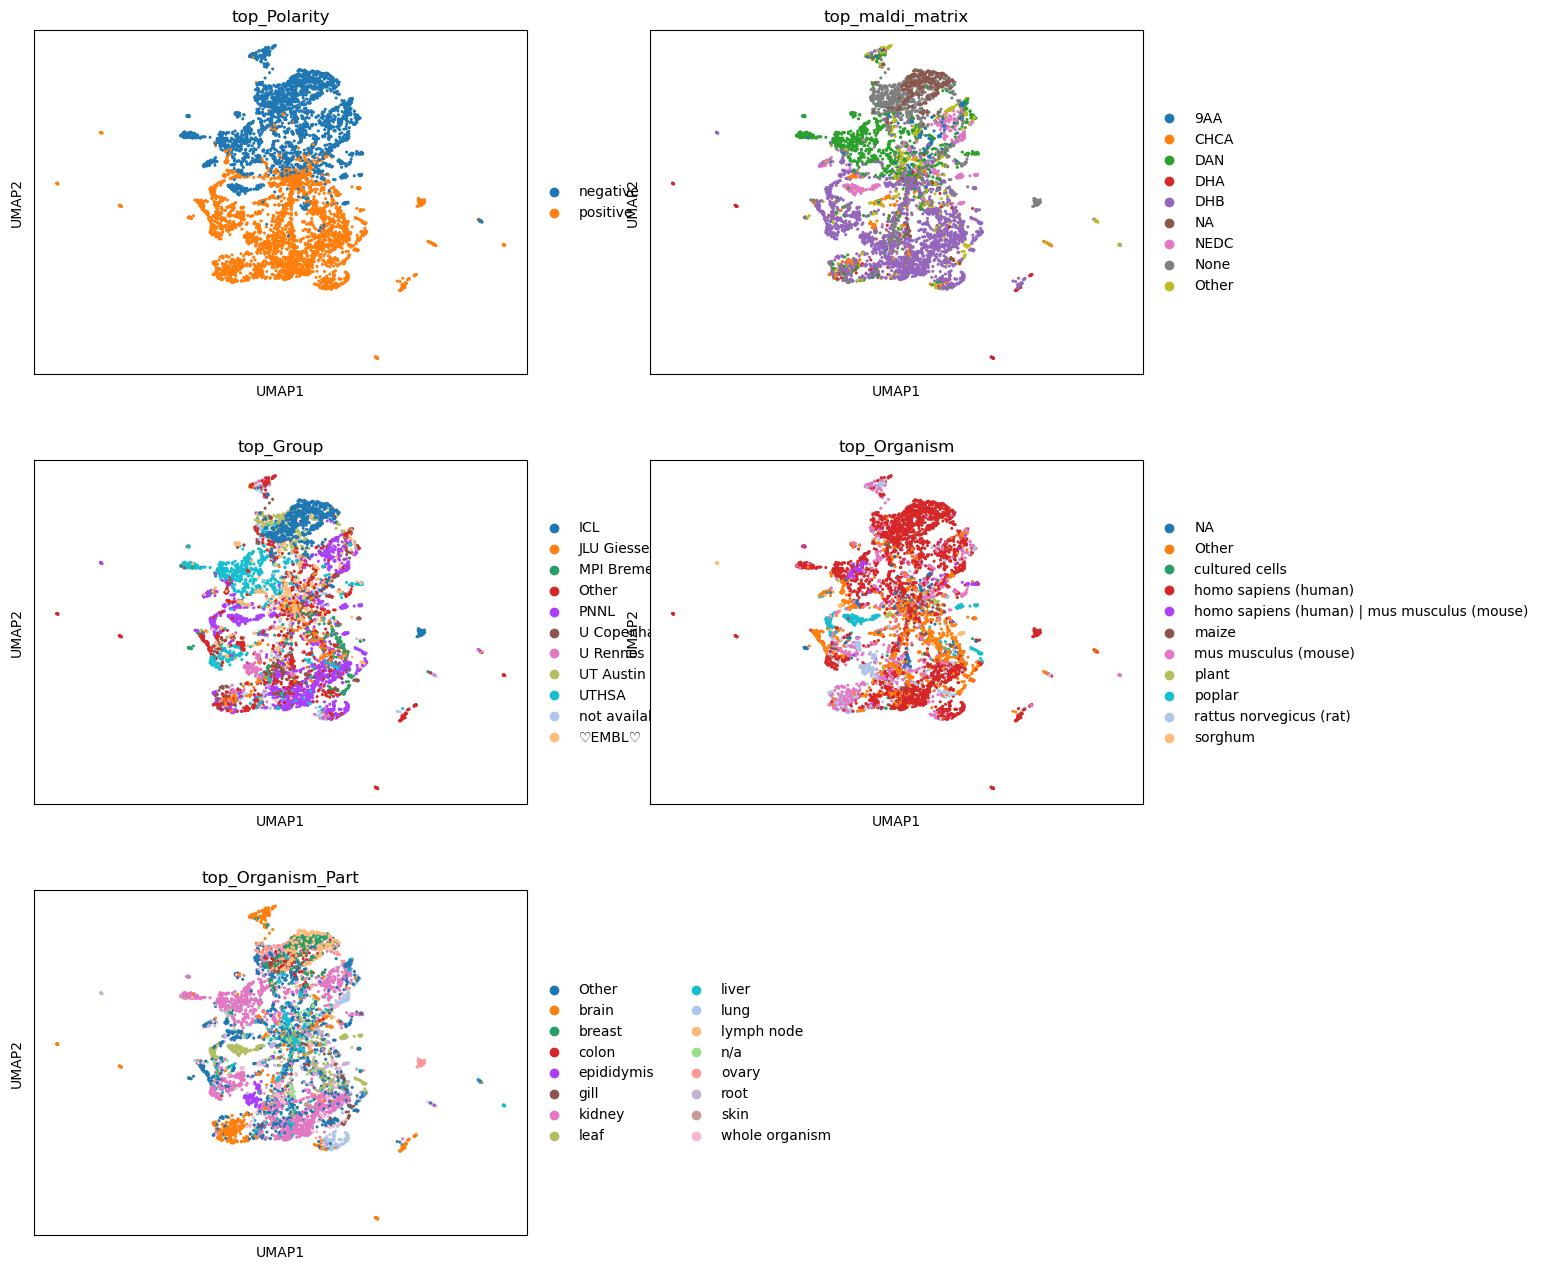

In [104]:
sc.pl.umap(adata, color=['top_Polarity', 'top_maldi_matrix', 'top_Group', 'top_Organism', 'top_Organism_Part'], ncols=2)

# Rank metabolites 

## Positive

In [105]:
adata_pos = adata[adata.obs['Polarity']=='positive',:]
sc.pp.filter_genes(adata_pos, min_cells=200)
sc.pp.filter_cells(adata_pos, min_genes=50)
# sc.pp.normalize_total(adata_pos, target_sum=1e4)

sc.pp.neighbors(adata_pos, metric='cosine')
sc.tl.leiden(adata_pos)
sc.tl.umap(adata_pos)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [165]:
sc.pp.log1p(adata)

In [106]:
sc.pp.log1p(adata_pos)
adata_pos.var = adata_pos.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

In [107]:
adata_pos.obs['is_brain'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'brain' if x=='brain' else 'other')
adata_pos.obs['is_liver'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'liver' if x=='liver' else 'other')
adata_pos.obs['is_kidney'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'kidney' if x=='kidney' else 'other')
adata_pos.obs['is_lung'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'lung' if x=='lung' else 'other')
adata_pos.obs['is_leaf'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'leaf' if x=='leaf' else 'other')
adata_pos.obs['is_colon'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'colon' if x=='colon' else 'other')
adata_pos.obs['is_ovary'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: '1_ovary' if x=='ovary' else 'other')
adata_pos.obs['is_breast'] = adata_pos.obs['top_Organism_Part'].apply(lambda x: 'breast' if x=='breast' else 'other')

In [134]:
sc.tl.rank_genes_groups(adata_pos, 'is_brain', key_added ='ranked_genes_brain', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_liver', key_added ='ranked_genes_liver', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_kidney', key_added ='ranked_genes_kidney', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_lung', key_added ='ranked_genes_lung', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_leaf', key_added ='ranked_genes_leaf', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_ovary', key_added ='ranked_genes_ovary', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_colon', key_added ='ranked_genes_colon', method='wilcoxon')
sc.tl.rank_genes_groups(adata_pos, 'is_breast', key_added ='ranked_genes_breast', method='wilcoxon')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: Mean of empty slice.
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:324: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in expm1
  self.expm1_func(mean_rest) + 1e-9


### Brain

In [135]:
adat.uns[f'ranked_genes_{code}']

{'params': {'groupby': 'is_brain',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('C48H91NO8', 'C37H66O4'), ('C45H78NO8P', 'C55H100O6'),
            ('C46H90NO10P', 'C12H22O11'), ...,
            ('C12H22O11', 'C46H90NO10P'), ('C55H100O6', 'C45H78NO8P'),
            ('C37H66O4', 'C48H91NO8')],
           dtype=[('brain', 'O'), ('other', 'O')]),
 'scores': rec.array([( 23.1436  ,  14.399822), ( 22.547417,  12.968692),
            ( 21.21409 ,  11.704356), ..., (-11.704356, -21.21409 ),
            (-12.968692, -22.547417), (-14.399822, -23.1436  )],
           dtype=[('brain', '<f4'), ('other', '<f4')]),
 'pvals': rec.array([(1.68630852e-118, 5.18770467e-047),
            (1.42357319e-112, 1.84145658e-038),
            (7.07824284e-100, 1.21074176e-031), ...,
            (1.21074176e-031, 7.07824284e-100),
            (1.84145658e-038, 1.42357319e-112),
            (5.18770467e-047, 1.6863

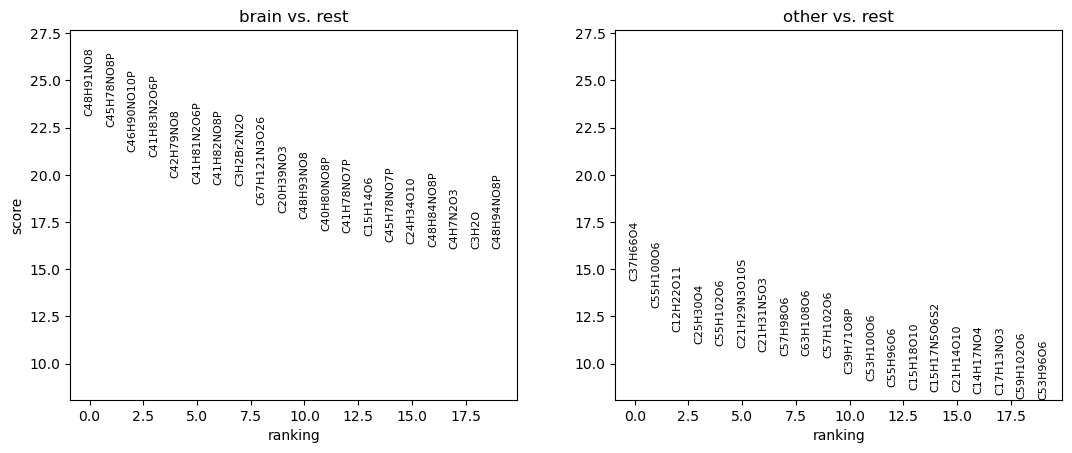

C48H91NO8  -  ['GlcCer(d18:1/24:1(15Z))', 'Galactosylceramide (d18:1/24:1(15Z))']
C45H78NO8P  -  ['PC(15:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PC(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/15:0)', 'PE(18:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(18:1(11Z)/22:5(4Z,7Z,10Z,13Z,16Z))']
C46H90NO10P  -  ['PS(16:0/24:0)', 'PS(18:0/22:0)', 'PS(20:0/20:0)', 'PS(22:0/18:0)']
C41H83N2O6P  -  ['SM(d18:1/18:0)', 'SM(d18:0/18:1(11Z))', 'SM(d18:0/18:1(9Z))']
C42H79NO8  -  ['GlcCer(d18:1/9Z-18:1)', 'Galactosylceramide (d18:1/18:1(9Z))']
C41H81N2O6P  -  ['SM(d18:1/18:1(11Z))', 'SM(d18:1/18:1(9Z))', 'SM(d18:2(4E,14Z)/18:0)']
C41H82NO8P  -  ['PC(15:0/18:0)', 'PC(18:0/15:0)', 'PE(14:0/22:0)', 'PE(16:0/20:0)']
C3H2Br2N2O  -  ['2,2-Dibromo-2-cyanoacetamide']
C67H121N3O26  -  ['Ganglioside GM2 (d18:1/18:0)']
C20H39NO3  -  ['Stearoylglycine', 'N-Palmitoyl GABA']
C48H93NO8  -  ['GlcCer(d18:1/24:0)']
C40H80NO8P  -  ['PC(16:0/16:0)', 'PC(14:0/18:0)', 'PC(18:0/14:0)', 'PE(15:0/20:0)']
C41H78NO7P  -  ['PE(18:1(11Z)/P-18:1(11Z))', 'PE(18:

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


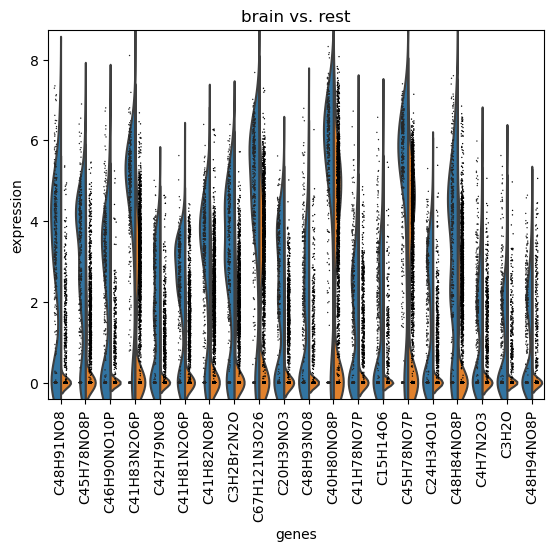

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


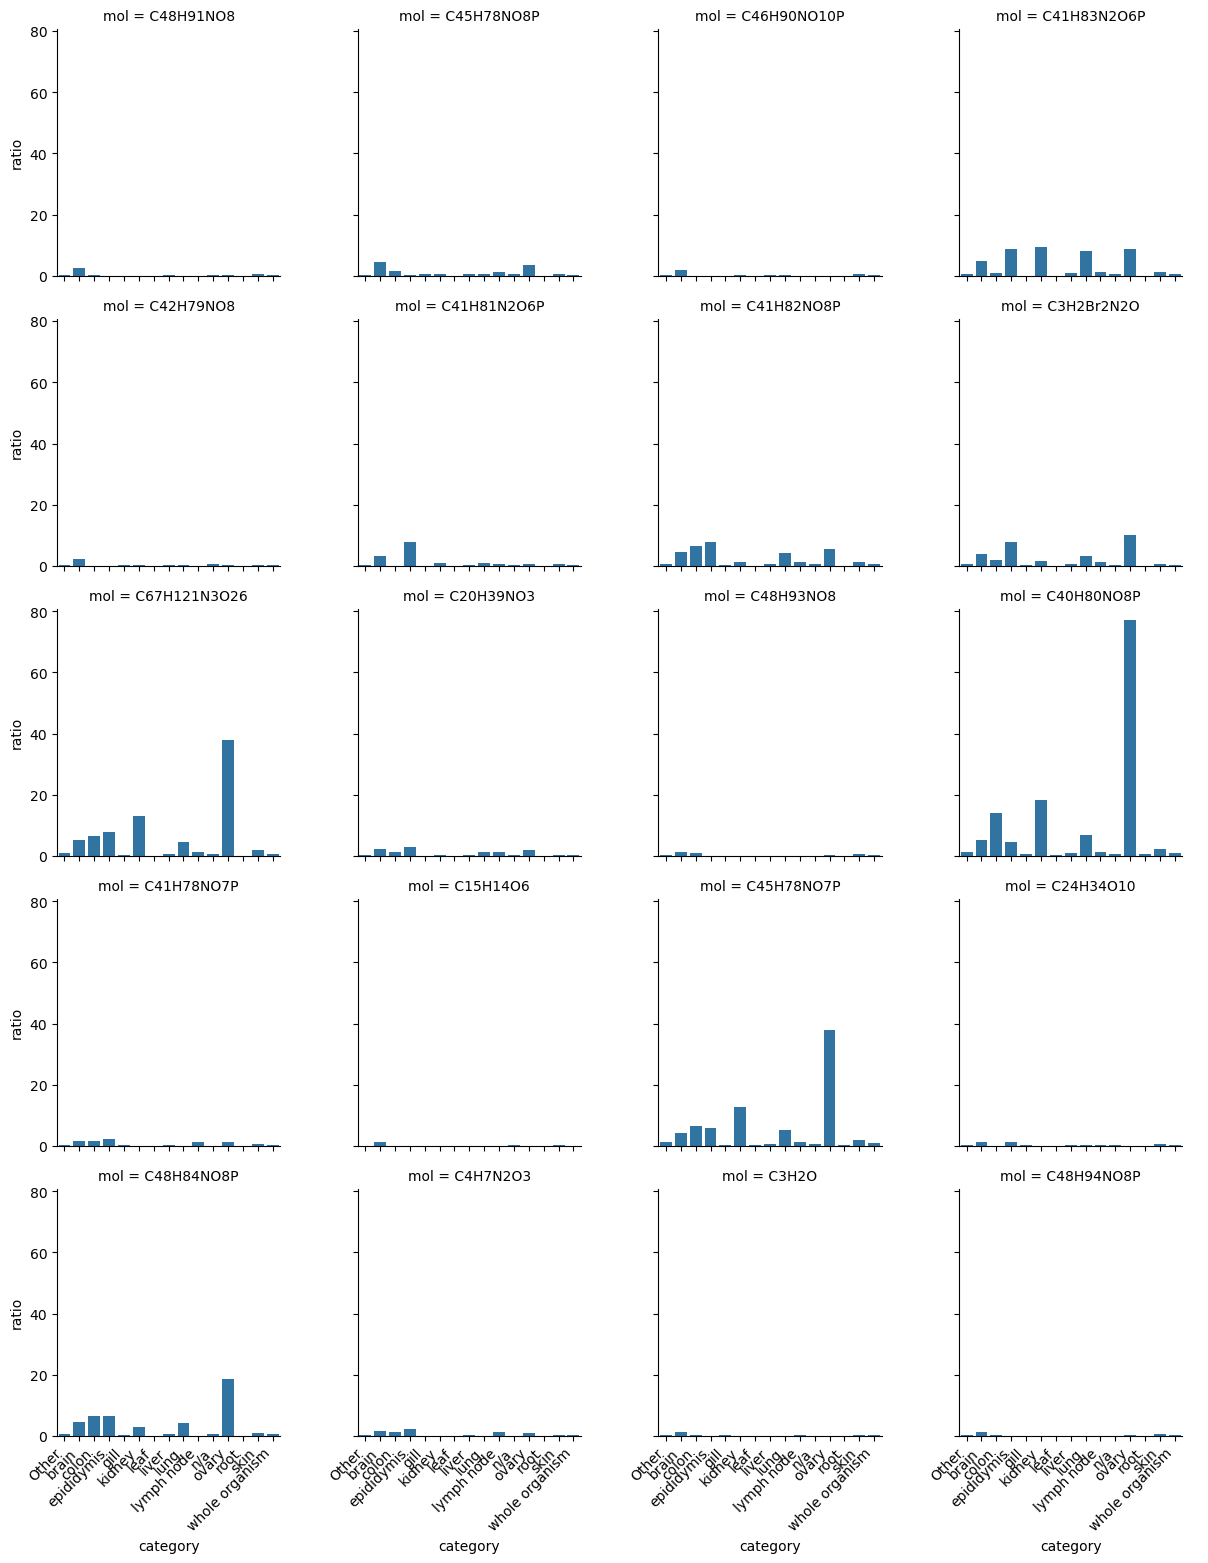

In [159]:
code = 'brain'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=20, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=20)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


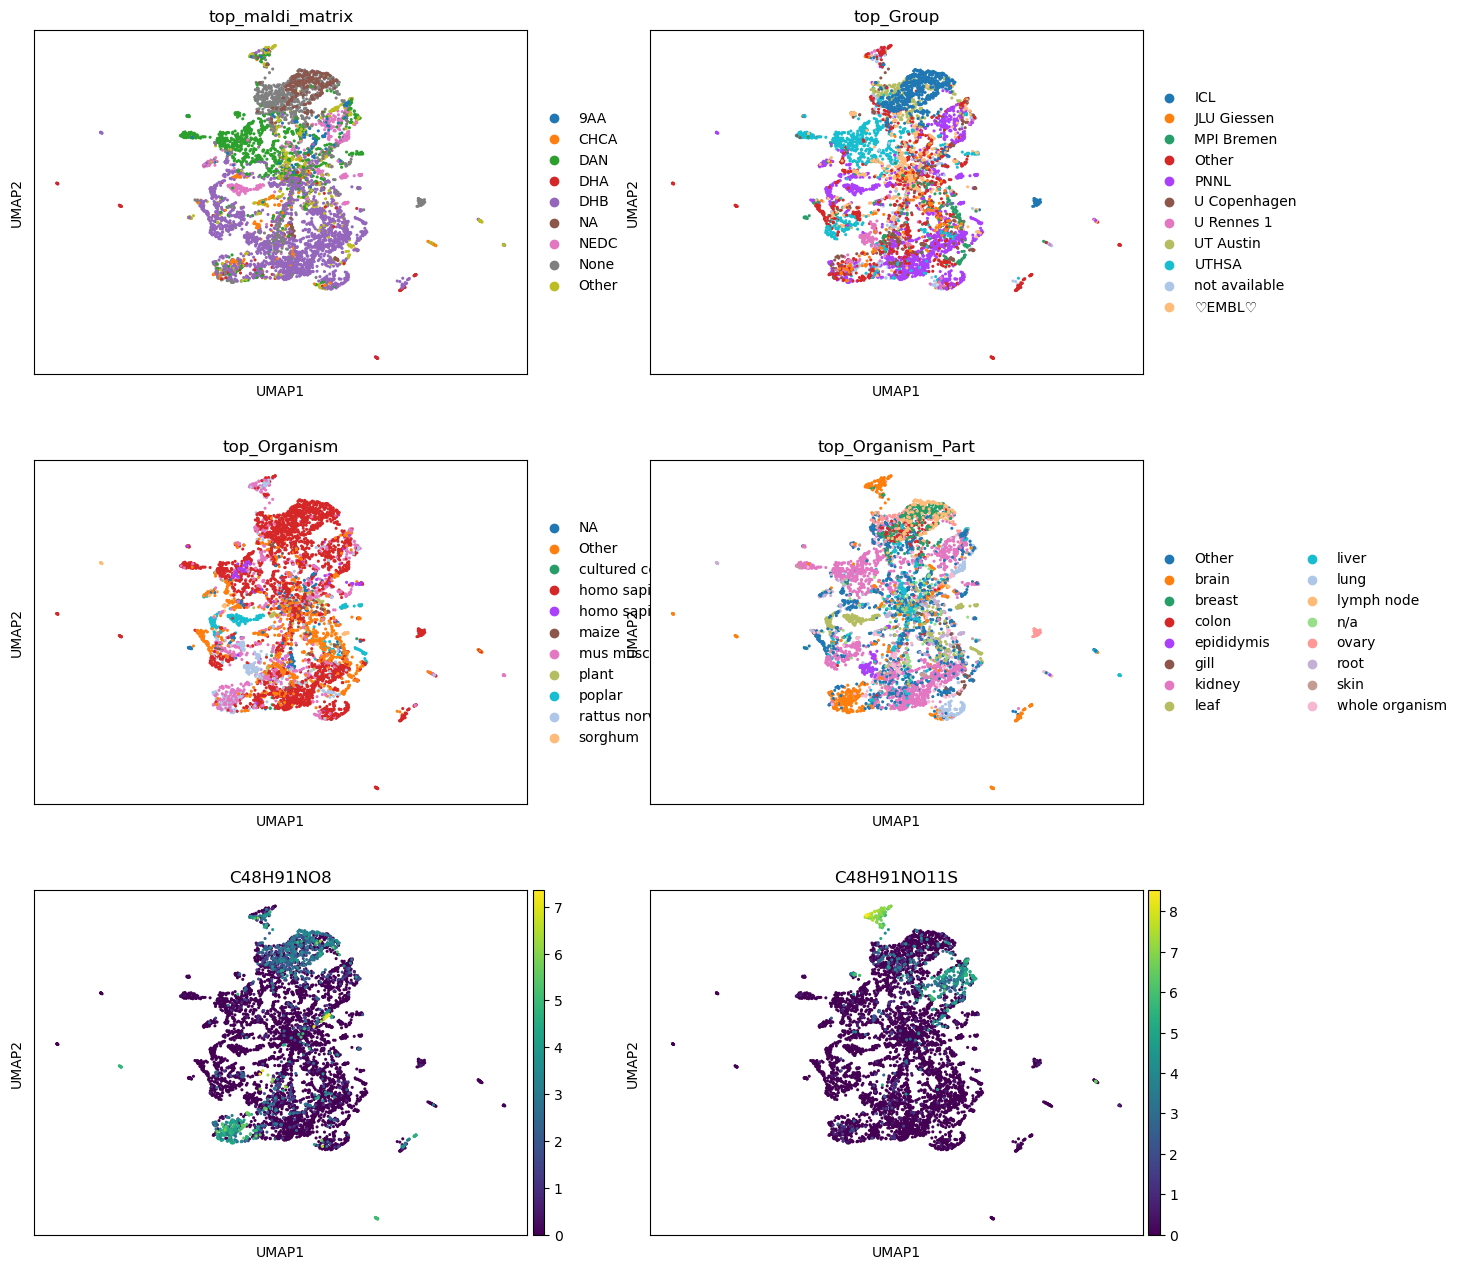

In [166]:
sc.pl.umap(adata, color=['top_maldi_matrix', 'top_Group', 
                             'top_Organism', 'top_Organism_Part', 'C48H91NO8', 'C48H91NO11S'], 
           ncols=2)


### Kidney

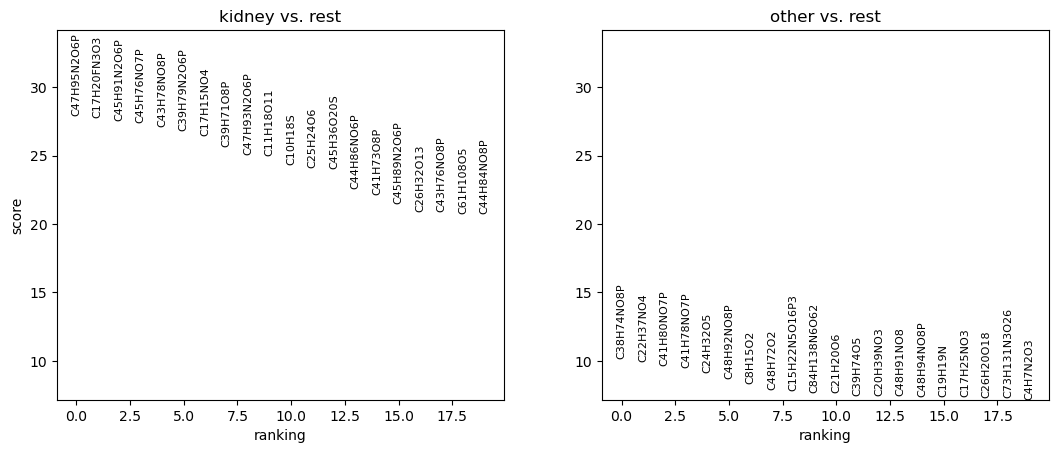

C47H95N2O6P  -  ['SM(d18:1/24:0)', 'SM(d18:0/24:1(15Z))']
C17H20FN3O3  -  ['Pefloxacin']
C45H91N2O6P  -  ['SM(d18:0/22:1(13Z))', 'SM(d18:1/22:0)']
C45H76NO7P  -  ['PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(11Z))', 'PE(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(P-18:1(9Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C43H78NO8P  -  ['PC(15:0/20:4(5Z,8Z,11Z,14Z))', 'PC(15:0/20:4(8Z,11Z,14Z,17Z))', 'PC(20:4(5Z,8Z,11Z,14Z)/15:0)', 'PC(20:4(8Z,11Z,14Z,17Z)/15:0)']
C39H79N2O6P  -  ['SM(d18:1/16:0)', 'SM(d18:0/16:1(9Z))']
C17H15NO4  -  ['(S)-Annocherine A']
C39H71O8P  -  ['PA(14:1(9Z)/22:2(13Z,16Z))', 'PA(16:0/20:3(5Z,8Z,11Z))', 'PA(18:0/18:3(6Z,9Z,12Z))', 'PA(18:0/18:3(9Z,12Z,15Z))']
C47H93N2O6P  -  ['SM(d18:1/24:1(15Z))', 'SM(d18:2(4E,14Z)/24:0)']
C11H18O11  -  ['3-O-alpha-D-Glucopyranuronosyl-D-xylose', 'Aldobiouronic acid D3', '6-[2-carboxy-2,2-bis(hydroxymethyl)ethoxy]-3,4,5-trihydroxyoxane-2-carboxylic acid', '3,4,5-trihydroxy-6-{[3-hydroxy-2,2-bis(hydroxy

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


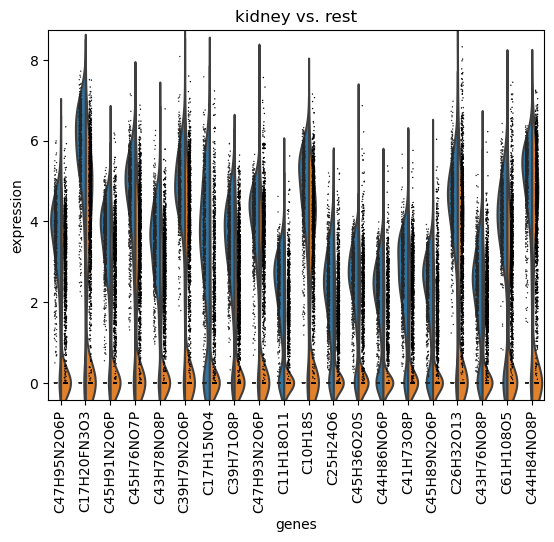

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


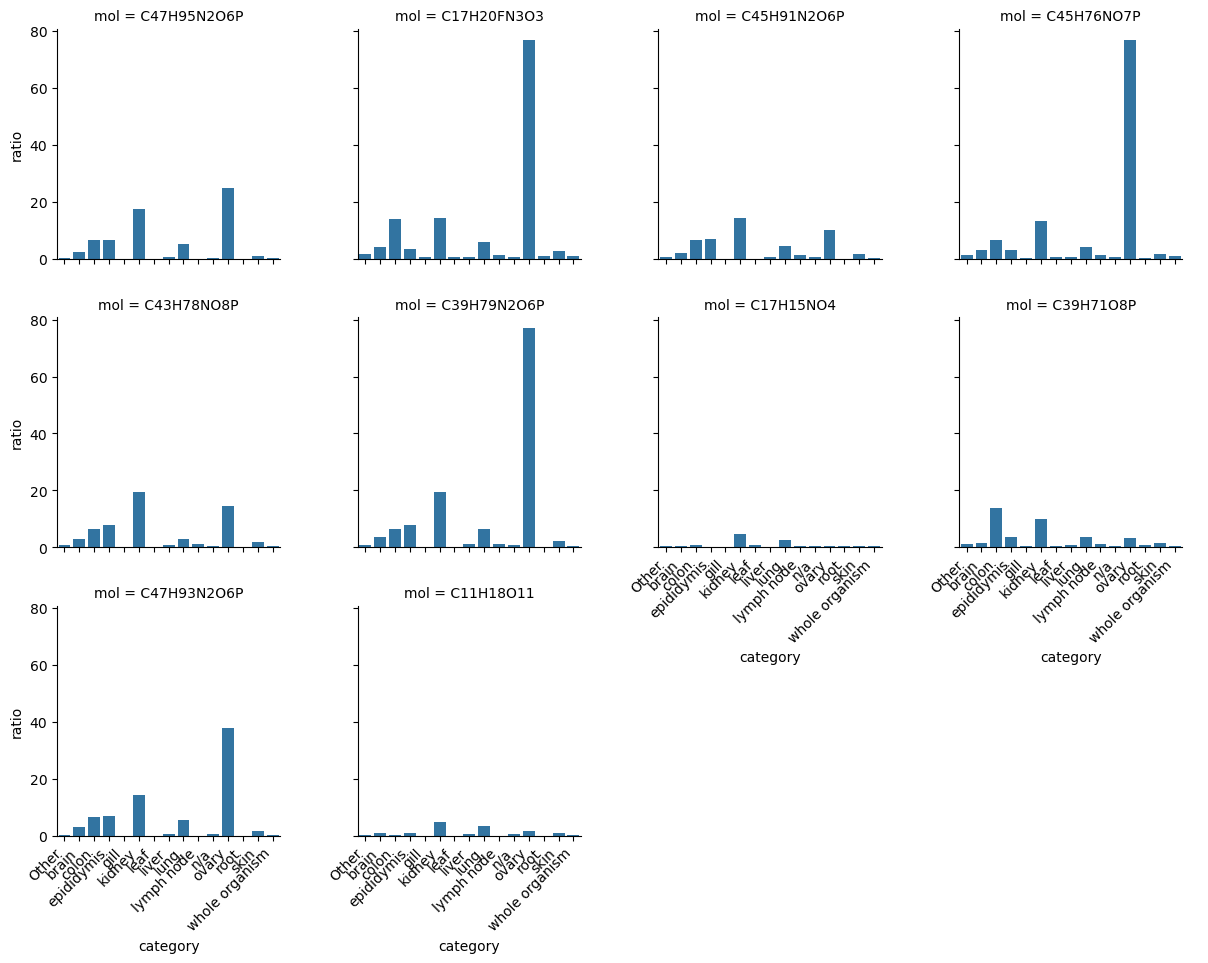

In [137]:
code = 'kidney'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Lung

In [138]:
utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=None)

array(['C47H95N2O6P', 'C17H20FN3O3', 'C45H91N2O6P', ..., 'C41H80NO7P',
       'C22H37NO4', 'C38H74NO8P'], dtype='<U15')

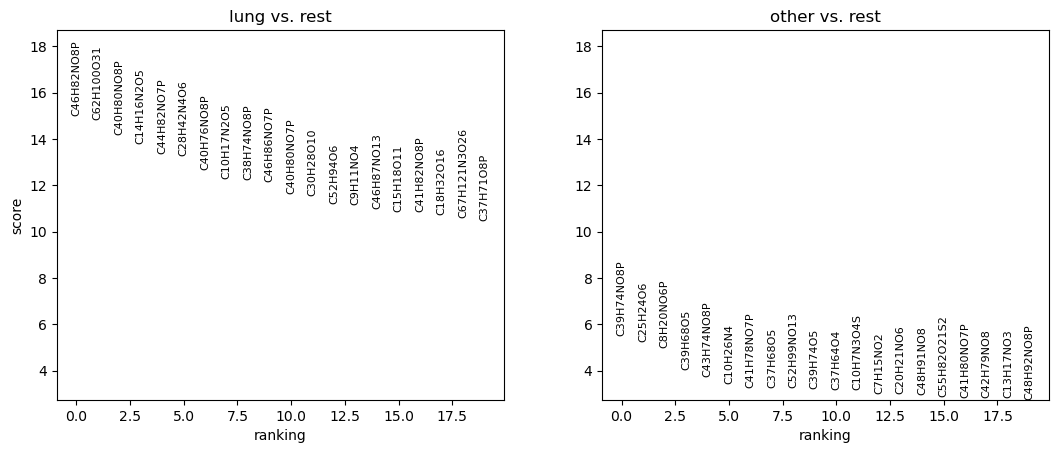

C46H82NO8P  -  ['PC(16:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(16:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(16:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C62H100O31  -  ['Agavasaponin E']
C40H80NO8P  -  ['PC(16:0/16:0)', 'PC(14:0/18:0)', 'PC(18:0/14:0)', 'PE(15:0/20:0)']
C14H16N2O5  -  ['(2S,4S)-Monatin']
C44H82NO7P  -  ['PC(18:2(9Z,12Z)/P-18:1(11Z))', 'PC(18:2(9Z,12Z)/P-18:1(9Z))', 'PC(18:3(6Z,9Z,12Z)/P-18:0)', 'PC(18:3(9Z,12Z,15Z)/P-18:0)']
C28H42N4O6  -  ['Kukoamine A', 'Kukoamine B', 'Kukoamine C', 'Kukoamine D']
C40H76NO8P  -  ['PC(14:0/18:2(9Z,12Z))', 'PC(14:1(9Z)/18:1(11Z))', 'PC(14:1(9Z)/18:1(9Z))', 'PC(16:1(9Z)/16:1(9Z))']
C10H17N2O5
C38H74NO8P  -  ['PC(14:0/16:1(9Z))', 'PC(14:1(9Z)/16:0)', 'PC(16:0/14:1(9Z))', 'PC(16:1(9Z)/14:0)']
C46H86NO7P  -  ['PC(20:2(11Z,14Z)/P-18:1(11Z))', 'PC(20:2(11Z,14Z)/P-18:1(9Z))', 'PC(20:3(5Z,8Z,11Z)/P-18:0)', 'PC(20:3(8Z,11Z,14Z)/P-18:0)']
C40H80NO7P  -  ['PC(14:0/P-18:0)', 'PC(16:0/P-16:0)', 'PC(P-16:0/16:0)', 'PC(P-18:0/14:0)']
C30H28O

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


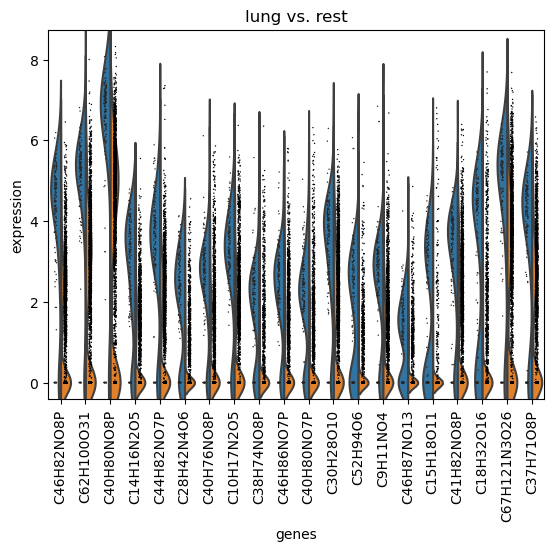

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


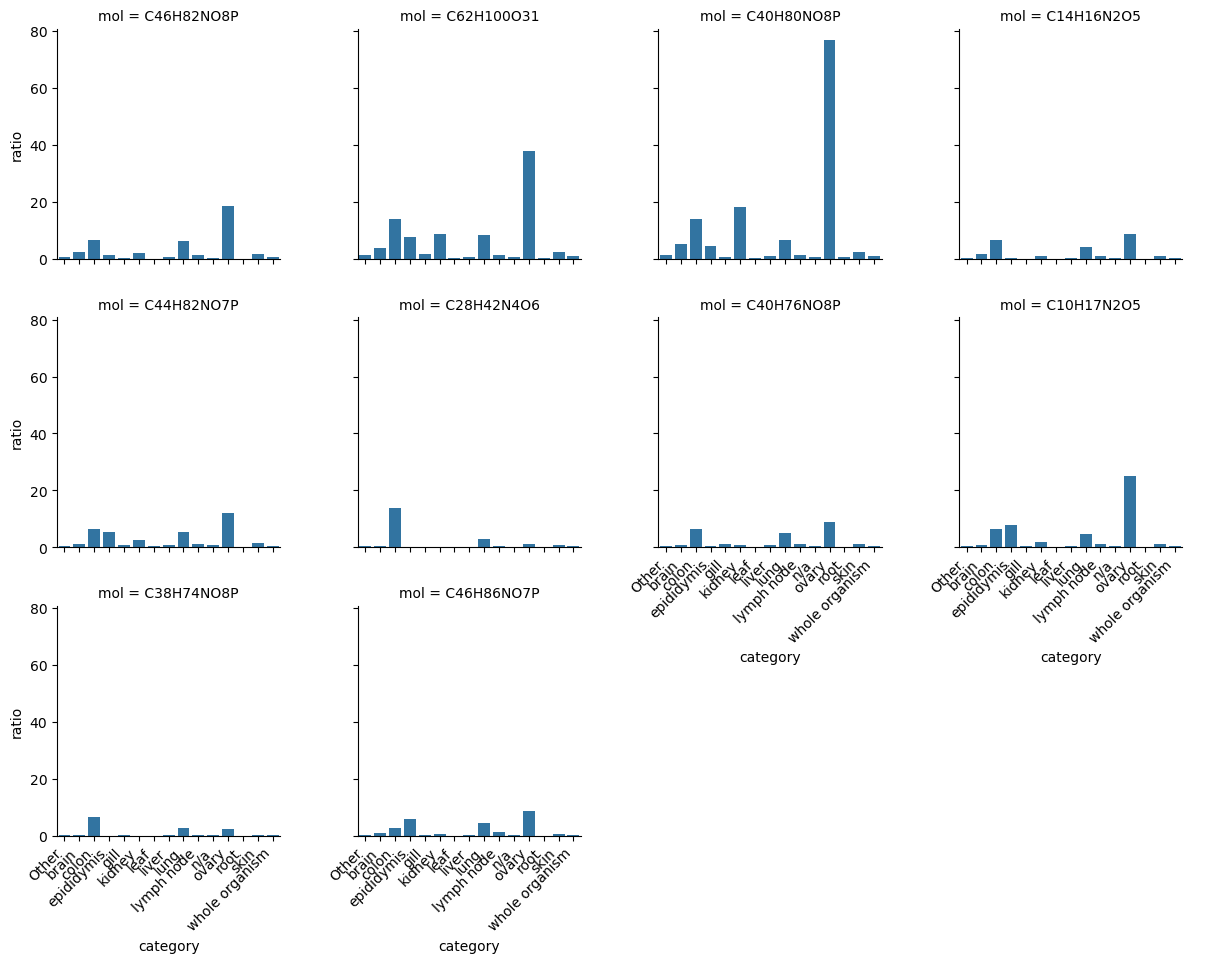

In [139]:
code = 'lung'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Liver

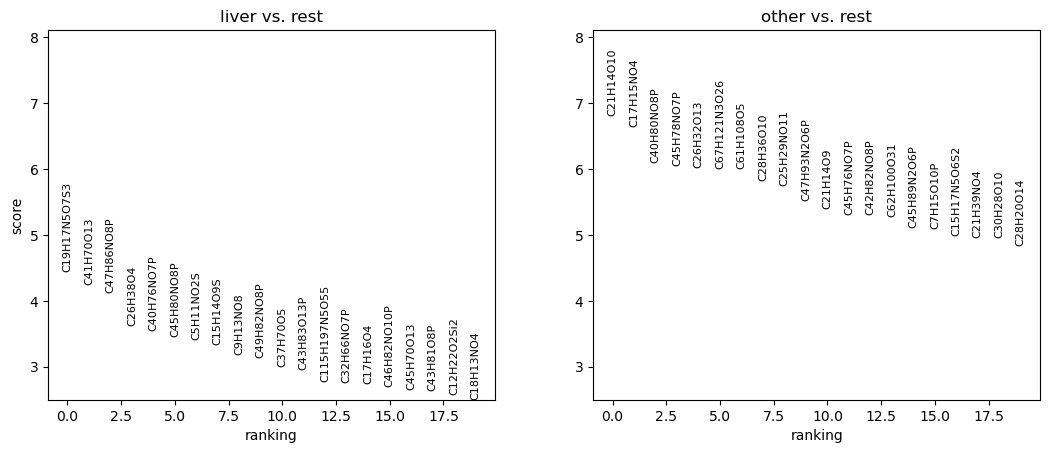

C19H17N5O7S3  -  ['Ceftiofur']
C41H70O13  -  ['Ginsenoside F5', 'Notoginsenoside R2', 'Ginsenoside F3', 'Pseudoginsenoside RT3']
C47H86NO8P  -  ['PE(18:3(6Z,9Z,12Z)/24:1(15Z))', 'PE(18:3(9Z,12Z,15Z)/24:1(15Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/24:0)', 'PE(20:0/22:4(7Z,10Z,13Z,16Z))']
C26H38O4  -  ["11'-Carboxy-alpha-tocotrienol", 'Lupulone', 'Adlupulone']
C40H76NO7P  -  ['PC(14:1(9Z)/P-18:1(11Z))', 'PC(14:1(9Z)/P-18:1(9Z))', 'PC(P-18:1(11Z)/14:1(9Z))', 'PC(P-18:1(9Z)/14:1(9Z))']
C45H80NO8P  -  ['PC(15:0/22:5(4Z,7Z,10Z,13Z,16Z))', 'PC(15:0/22:5(7Z,10Z,13Z,16Z,19Z))', 'PC(22:5(4Z,7Z,10Z,13Z,16Z)/15:0)', 'PC(22:5(7Z,10Z,13Z,16Z,19Z)/15:0)']
C5H11NO2S  -  ['L-Methionine', 'Penicillamine', 'Racemethionine']
C15H14O9S  -  ['[2-hydroxy-5-(3,5,7-trihydroxy-3,4-dihydro-2H-1-benzopyran-2-yl)phenyl]oxidanesulfonic acid', '{4-[1-oxo-1-(2,3,4,6-tetrahydroxyphenyl)propan-2-yl]phenyl}oxidanesulfonic acid', '{4-[3-oxo-3-(2,3,4,6-tetrahydroxyphenyl)propyl]phenyl}oxidanesulfonic acid', '{4-[(2,3,4,6-tetrahydrox

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


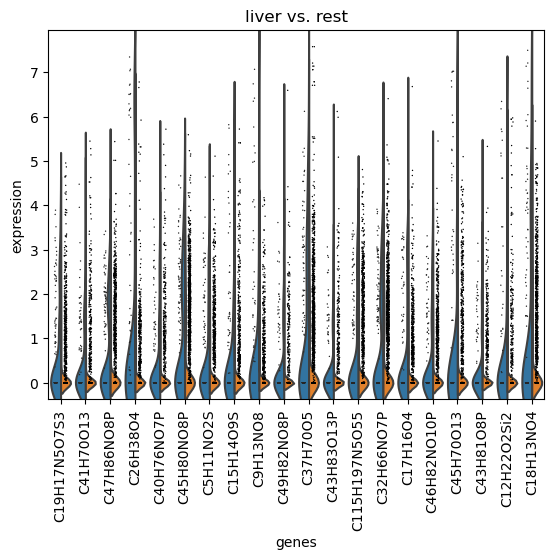

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


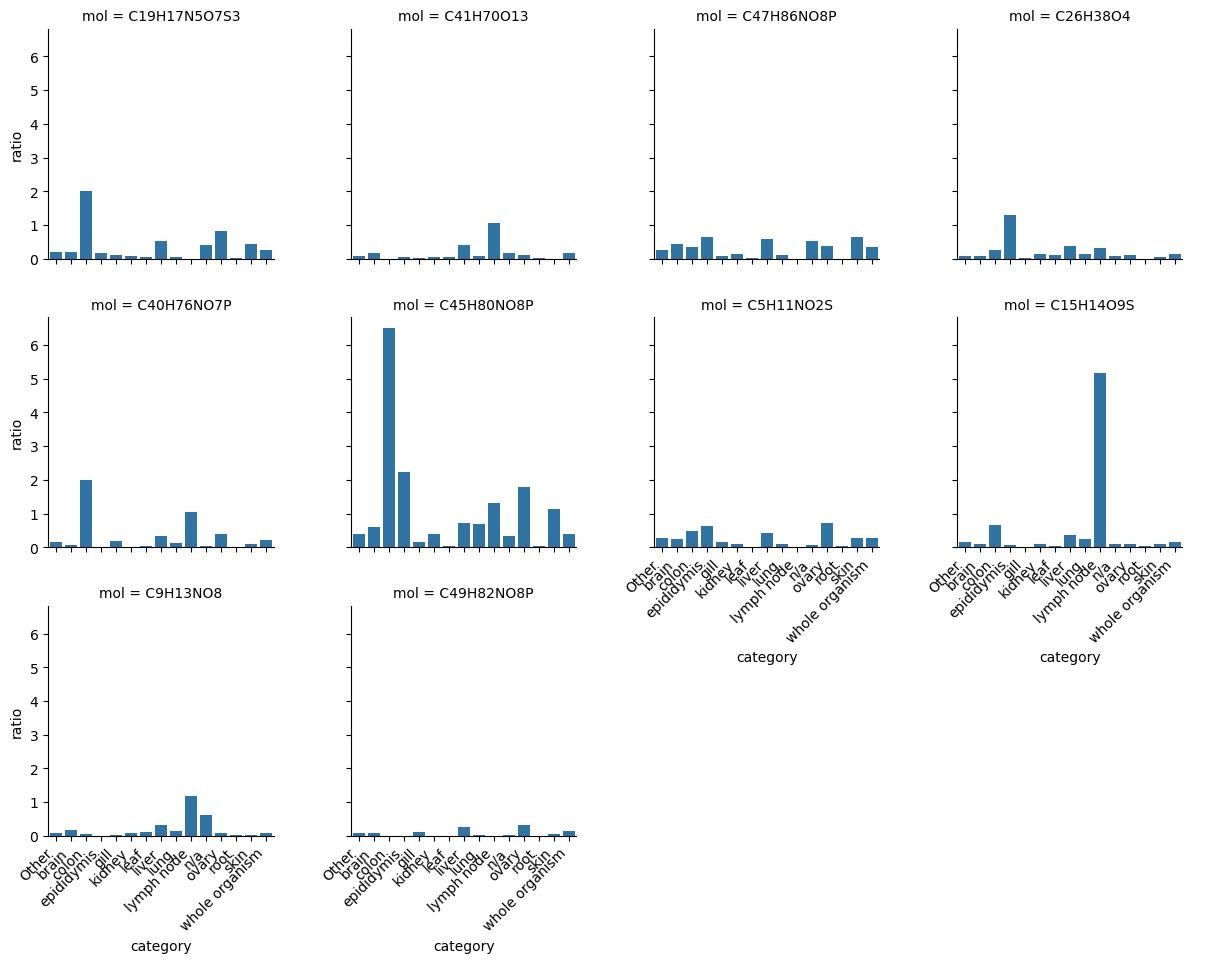

In [140]:
code = 'liver'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Leaf

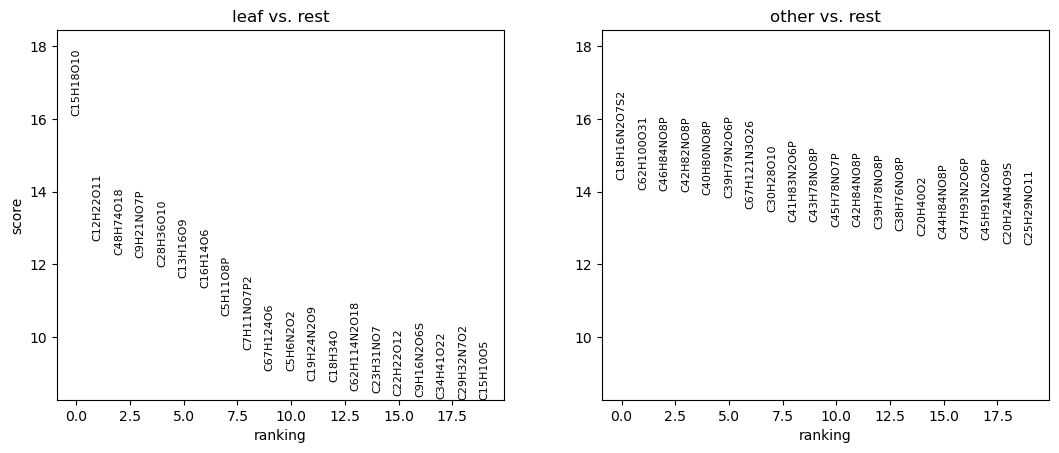

C15H18O10  -  ['Dihydrocaffeic acid 3-O-glucuronide', '6-[4-(2-carboxyethyl)-2-hydroxyphenoxy]-3,4,5-trihydroxyoxane-2-carboxylic acid', '6-[5-(2-carboxyethyl)-2-hydroxyphenoxy]-3,4,5-trihydroxyoxane-2-carboxylic acid', '6-{[3-(3,4-dihydroxyphenyl)propanoyl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid']
C12H22O11  -  ['Melibiose', 'Cellobiose', 'D-Maltose', 'Alpha-Lactose']
C48H74O18  -  ['AzI']
C9H21NO7P
C28H36O10  -  ['Austalide D', 'Austalide E', 'Nomilinic acid']
C13H16O9  -  ['3,4,5-trihydroxy-6-(2-hydroxy-3-methoxyphenoxy)oxane-2-carboxylic acid', '3,4,5-trihydroxy-6-(2-hydroxy-6-methoxyphenoxy)oxane-2-carboxylic acid']
C16H14O6  -  ['Hesperetin', 'Isoferreirin', "5,7,3'-Trihydroxy-4'-methoxyflavanone", 'Ferreirin']
C5H11O8P  -  ['D-Ribulose 5-phosphate', 'Xylulose 5-phosphate', 'Ribose 1-phosphate', 'D-Ribose 5-phosphate']
C7H11NO7P2  -  ['Risedronate']
C67H124O6  -  ['TG(18:0/24:1(15Z)/22:2(13Z,16Z))', 'TG(18:0/22:2(13Z,16Z)/24:1(15Z))', 'TG(20:0/24:0/20:3(5Z,8Z,11Z))', 'TG(20:

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


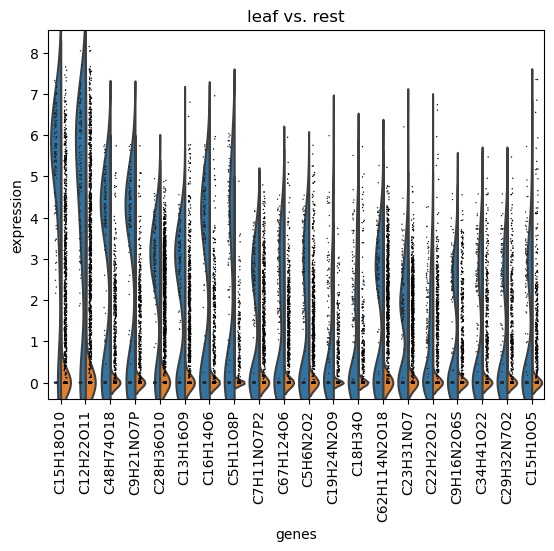

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


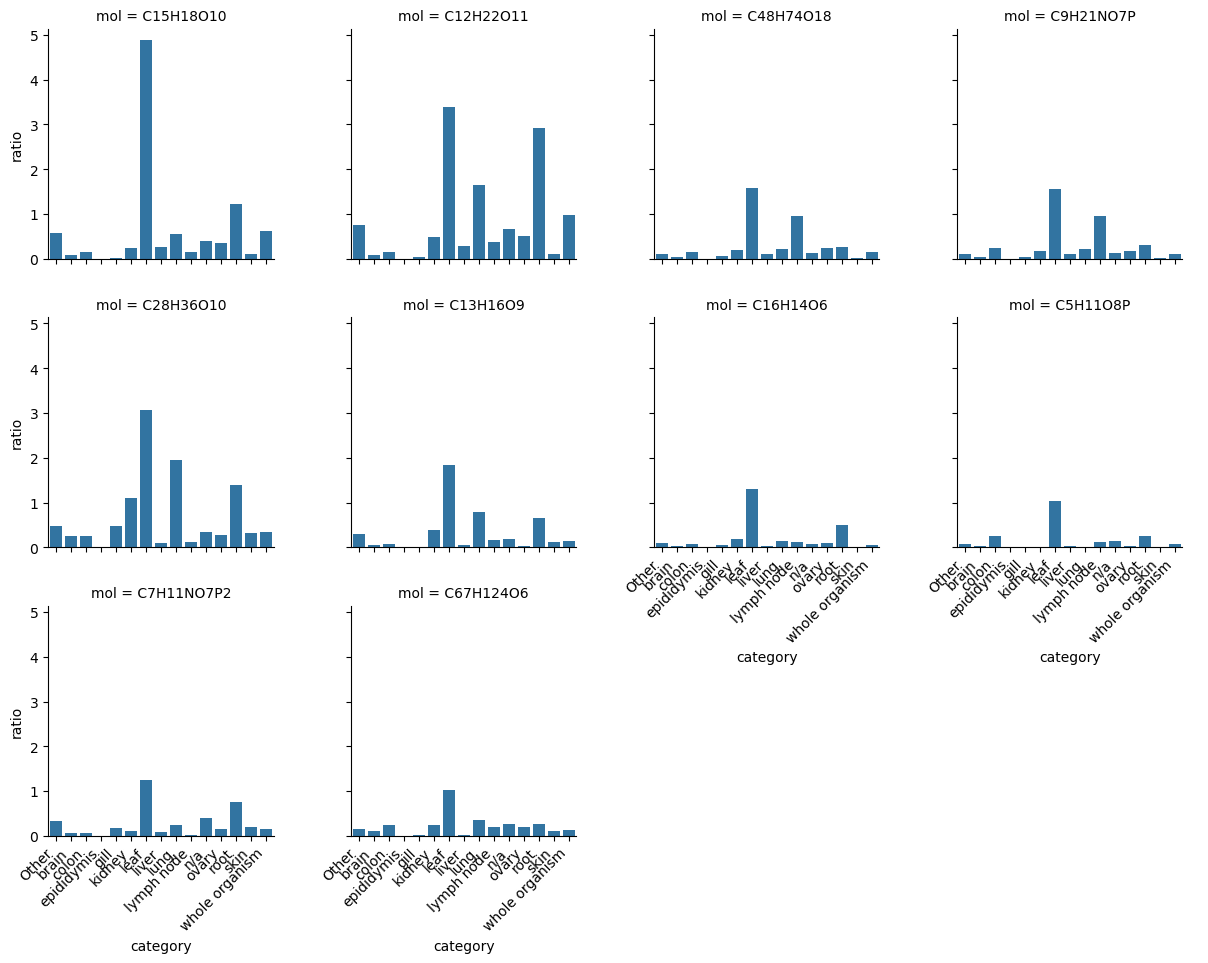

In [141]:
code = 'leaf'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Colon

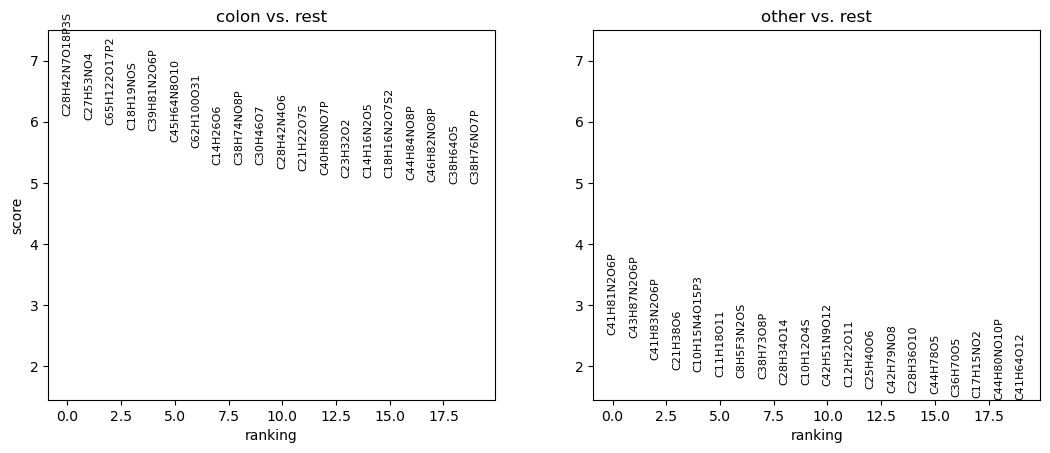

C28H42N7O18P3S  -  ['6-Oxocyclohex-1-ene-1-carboxyl-CoA']
C27H53NO4  -  ['Arachidyl carnitine']
C65H122O17P2  -  ['CL(i-14:0/i-12:0/i-12:0/18:2(9Z,11Z))', 'CL(i-14:0/i-12:0/18:2(9Z,11Z)/i-12:0)', 'CL(i-12:0/18:2(9Z,11Z)/i-12:0/i-14:0)', 'CL(i-12:0/18:2(9Z,11Z)/a-13:0/i-13:0)[rac]']
C18H19NOS  -  ['Duloxetine']
C39H81N2O6P  -  ['SM(d18:0/16:0)']
C45H64N8O10  -  ['Spinorphin']
C62H100O31  -  ['Agavasaponin E']
C14H26O6  -  ['1-Octen-3-yl glucoside']
C38H74NO8P  -  ['PC(14:0/16:1(9Z))', 'PC(14:1(9Z)/16:0)', 'PC(16:0/14:1(9Z))', 'PC(16:1(9Z)/14:0)']
C30H46O7  -  ['Perulactone', 'Ganoderic acid C2', 'Corosin', 'Ganolucidic acid C']
C28H42N4O6  -  ['Kukoamine A', 'Kukoamine B', 'Kukoamine C', 'Kukoamine D']
C21H22O7S  -  ['{4-[3-(5-methoxy-2,2-dimethyl-2H-chromen-6-yl)propanoyl]phenyl}oxidanesulfonic acid', '{4-[1-hydroxy-3-(5-methoxy-2,2-dimethyl-2H-chromen-6-yl)prop-2-en-1-yl]phenyl}oxidanesulfonic acid', '{[1-(4-hydroxyphenyl)-3-(5-methoxy-2,2-dimethyl-2H-chromen-6-yl)prop-2-en-1-yl]oxy}s

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


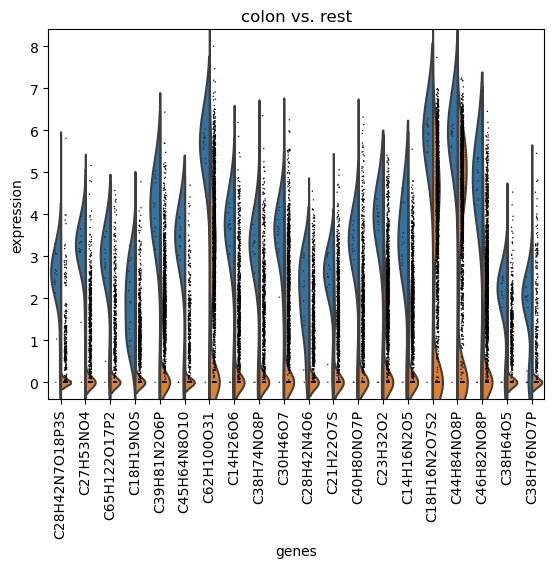

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


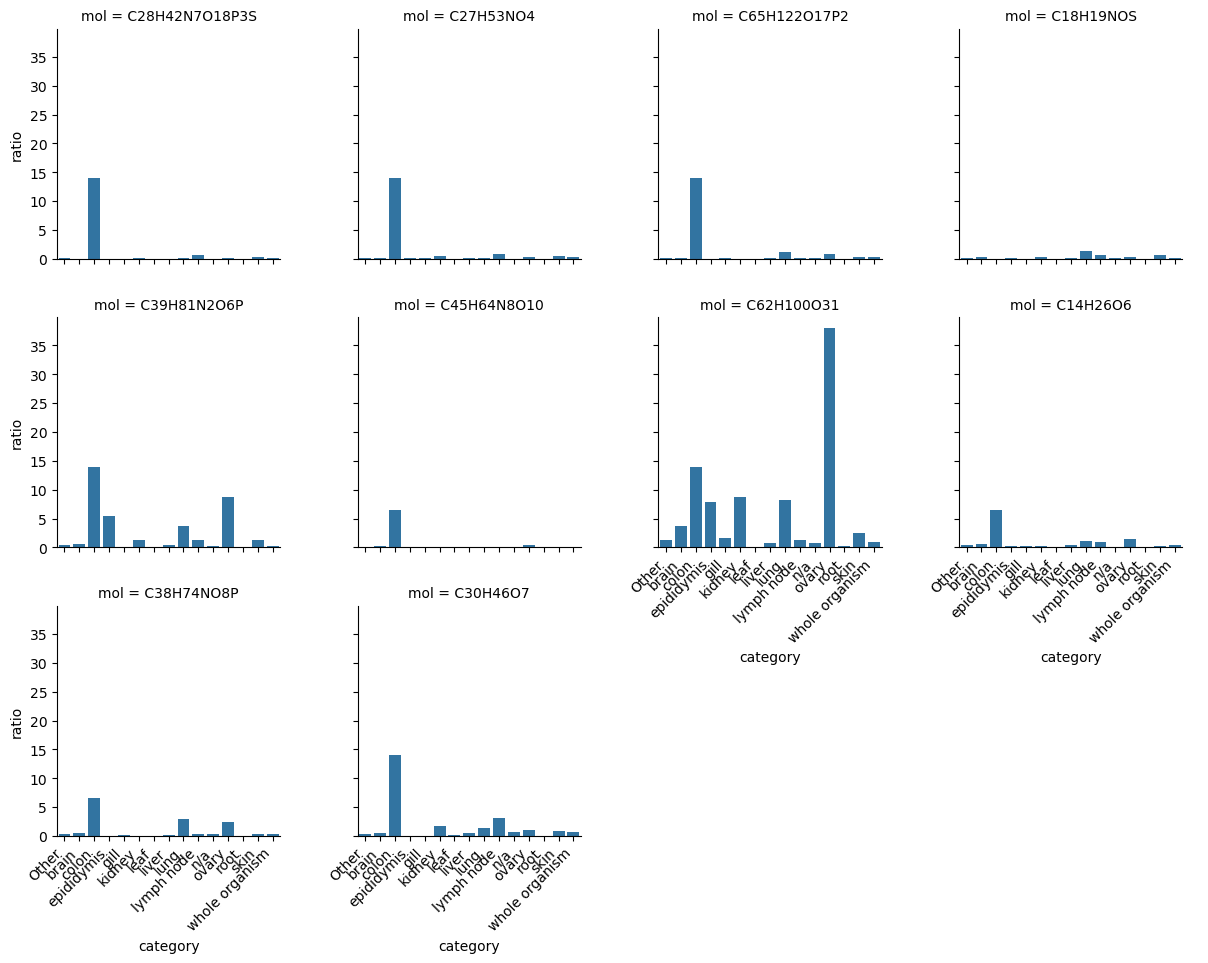

In [142]:
code = 'colon'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Ovary

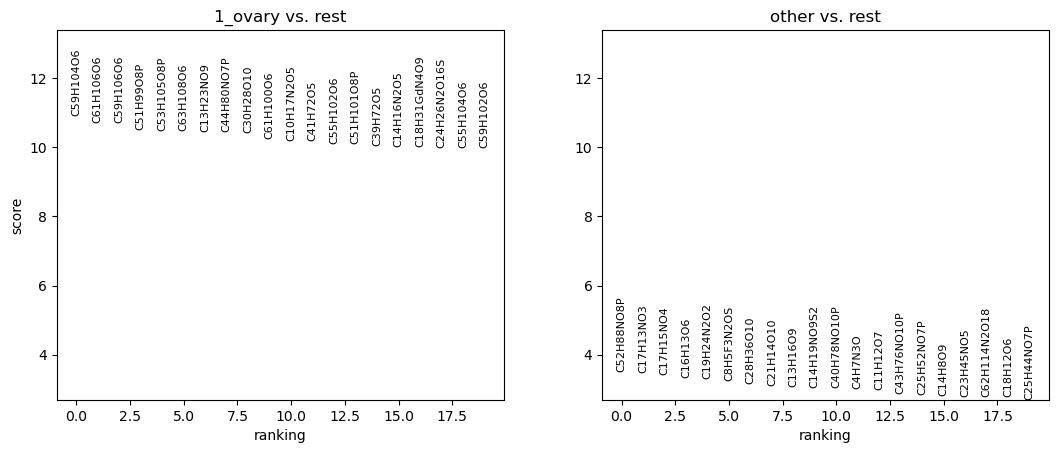

C59H104O6  -  ['TG(16:0/20:1(11Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/20:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:2(9Z,12Z)/18:2(9Z,12Z)/20:1(11Z))']
C61H106O6  -  ['TG(18:1(9Z)/20:1(11Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(18:2(9Z,12Z)/20:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:1(9Z)/22:4(7Z,10Z,13Z,16Z))', 'TG(14:0/22:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))']
C59H106O6  -  ['TG(16:0/20:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:0/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/20:1(11Z))', 'TG(18:2(9Z,12Z)/18:2(9Z,12Z)/20:0)']
C51H99O8P  -  ['PA(24:0/24:1(15Z))', 'PA(24:1(15Z)/24:0)']
C53H105O8P  -  ['PA(a-25:0/a-25:0)']
C63H108O6  -  ['TG(14:0/24:1(15Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'TG(14:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z)/24:1(15Z))', 'TG(16:0/22:1(13Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'TG(16:0/22:2(13Z,16Z)/22:5(4Z,7Z,10Z,13Z,16Z))']
C13H23NO9  -  ['4-O-alpha-D-Galactopyranosylcalystegine B2']
C44H80NO7P  -  ['PC(18:3(6Z,9Z,12Z)/P-18:1(11Z))', 'PC(18:3(6Z,9Z,12Z)/P-18:1(9Z))'

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


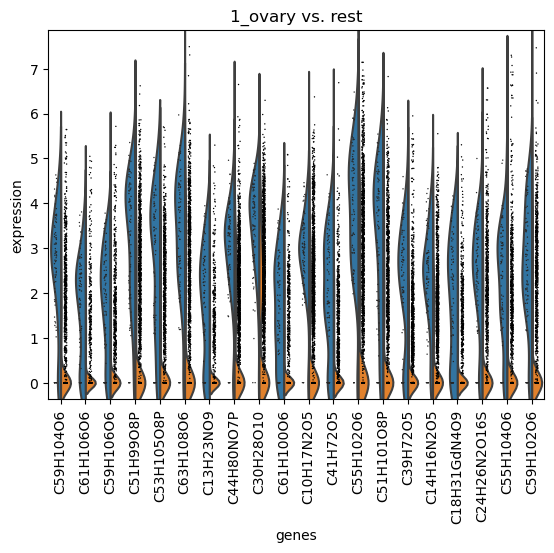

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


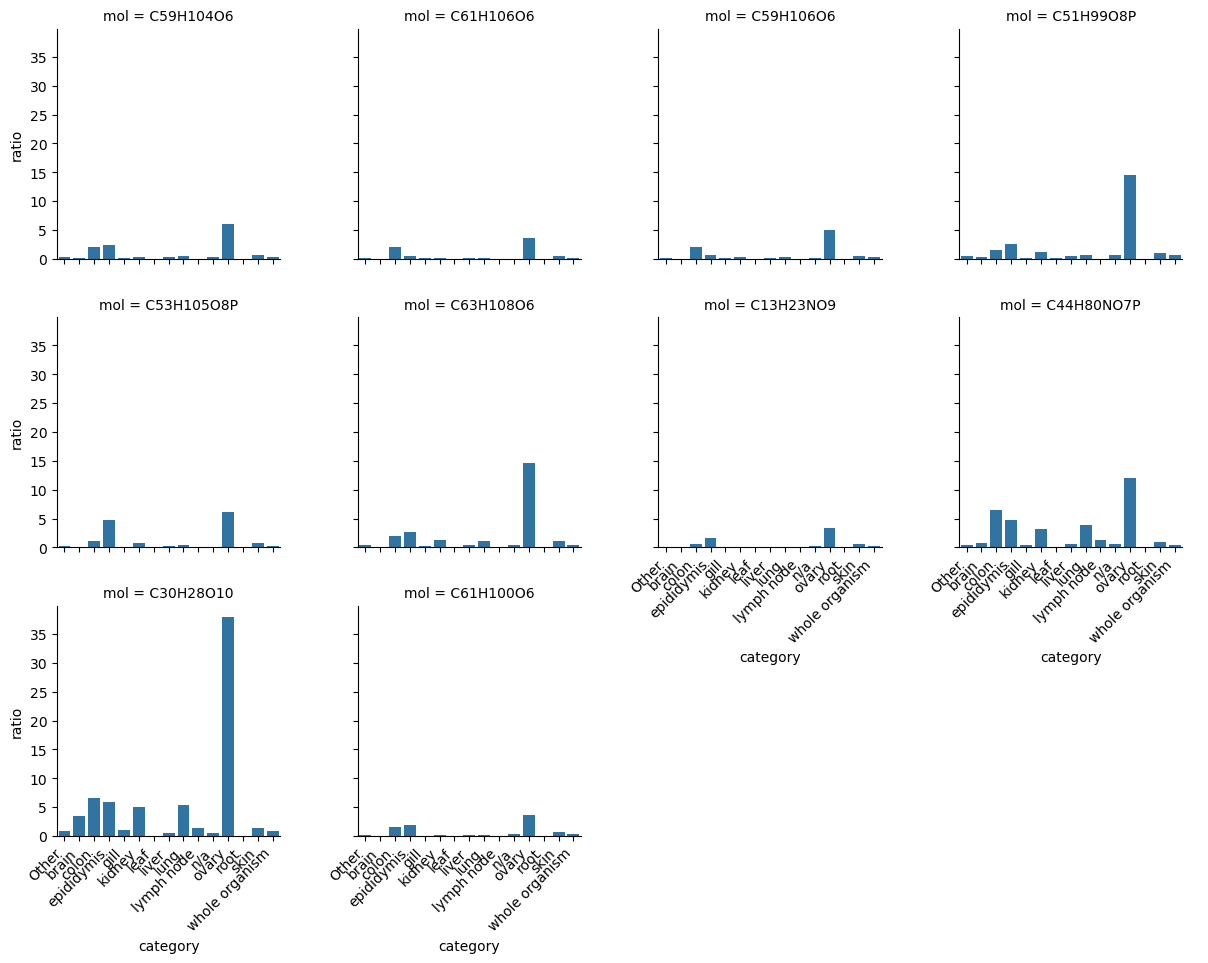

In [143]:
code = 'ovary'
adat = adata_pos

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups='1_ovary')

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

## Negative

In [147]:
adata_neg = adata[adata.obs['Polarity']=='negative',:]
sc.pp.filter_genes(adata_neg, min_cells=200)
sc.pp.filter_cells(adata_neg, min_genes=50)
# sc.pp.normalize_total(adata_pos, target_sum=1e4)

sc.pp.neighbors(adata_neg, metric='cosine')
sc.tl.leiden(adata_neg)
sc.tl.umap(adata_neg)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [148]:
sc.pp.log1p(adata_neg)
adata_neg.var = adata_neg.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

In [149]:
adata_neg.obs['is_brain'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'brain' if x=='brain' else 'other')
adata_neg.obs['is_liver'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'liver' if x=='liver' else 'other')
adata_neg.obs['is_kidney'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'kidney' if x=='kidney' else 'other')
adata_neg.obs['is_lung'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'lung' if x=='lung' else 'other')
adata_neg.obs['is_leaf'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'leaf' if x=='leaf' else 'other')
adata_neg.obs['is_colon'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'colon' if x=='colon' else 'other')
adata_neg.obs['is_ovary'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: '1_ovary' if x=='ovary' else 'other')
adata_neg.obs['is_breast'] = adata_neg.obs['top_Organism_Part'].apply(lambda x: 'breast' if x=='breast' else 'other')

In [150]:
sc.tl.rank_genes_groups(adata_neg, 'is_brain', key_added ='ranked_genes_brain', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_liver', key_added ='ranked_genes_liver', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_kidney', key_added ='ranked_genes_kidney', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_lung', key_added ='ranked_genes_lung', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_leaf', key_added ='ranked_genes_leaf', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_ovary', key_added ='ranked_genes_ovary', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_colon', key_added ='ranked_genes_colon', method='wilcoxon')
sc.tl.rank_genes_groups(adata_neg, 'is_breast', key_added ='ranked_genes_breast', method='wilcoxon')

### Brain

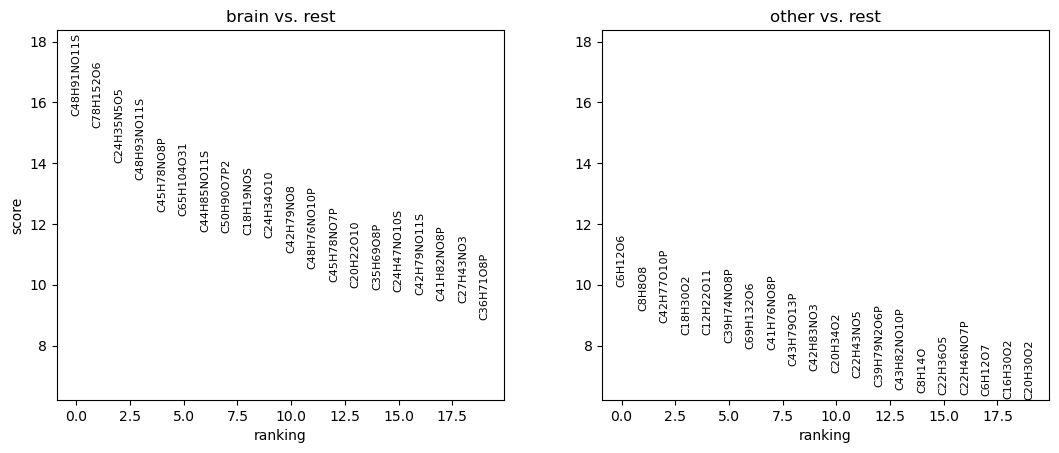

C48H91NO11S  -  ['3-O-Sulfogalactosylceramide (d18:1/24:1(15Z))']
C78H152O6  -  ['TG(a-25:0/a-25:0/a-25:0)[rac]']
C24H35N5O5  -  ['Ximelagatran']
C48H93NO11S  -  ['3-O-Sulfogalactosylceramide (d18:1/24:0)']
C45H78NO8P  -  ['PC(15:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PC(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/15:0)', 'PE(18:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PE(18:1(11Z)/22:5(4Z,7Z,10Z,13Z,16Z))']
C65H104O31  -  ['Phaseoloside D']
C44H85NO11S  -  ['3-O-Sulfogalactosylceramide (d18:1/20:0)']
C50H90O7P2  -  ['All trans decaprenyl diphosphate']
C18H19NOS  -  ['Duloxetine']
C24H34O10  -  ["3'-Hydroxy-T2 Toxin"]
C42H79NO8  -  ['GlcCer(d18:1/9Z-18:1)', 'Galactosylceramide (d18:1/18:1(9Z))']
C48H76NO10P  -  ['PS(20:3(8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:3(8Z,11Z,14Z))', 'PS(20:4(5Z,8Z,11Z,14Z)/22:5(4Z,7Z,10Z,13Z,16Z))', 'PS(20:4(5Z,8Z,11Z,14Z)/22:5(7Z,10Z,13Z,16Z,19Z))']
C45H78NO7P  -  ['PE(22:5(4Z,7Z,10Z,13Z,16Z)/P-18:1(11Z))', 'PE(22:5(4Z,7Z,10Z,13Z,16Z)/P-18:1(9Z))'

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


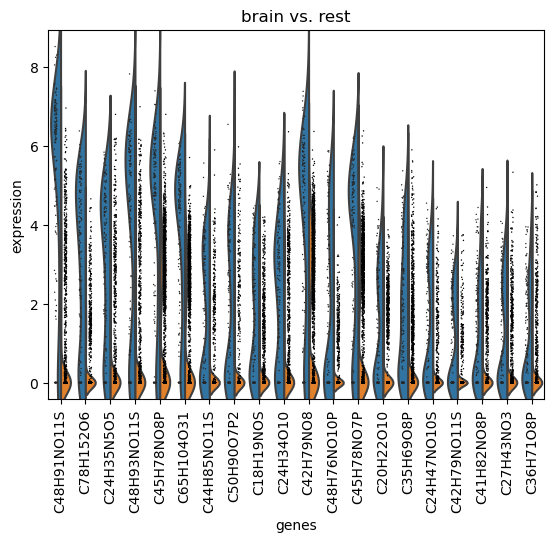

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


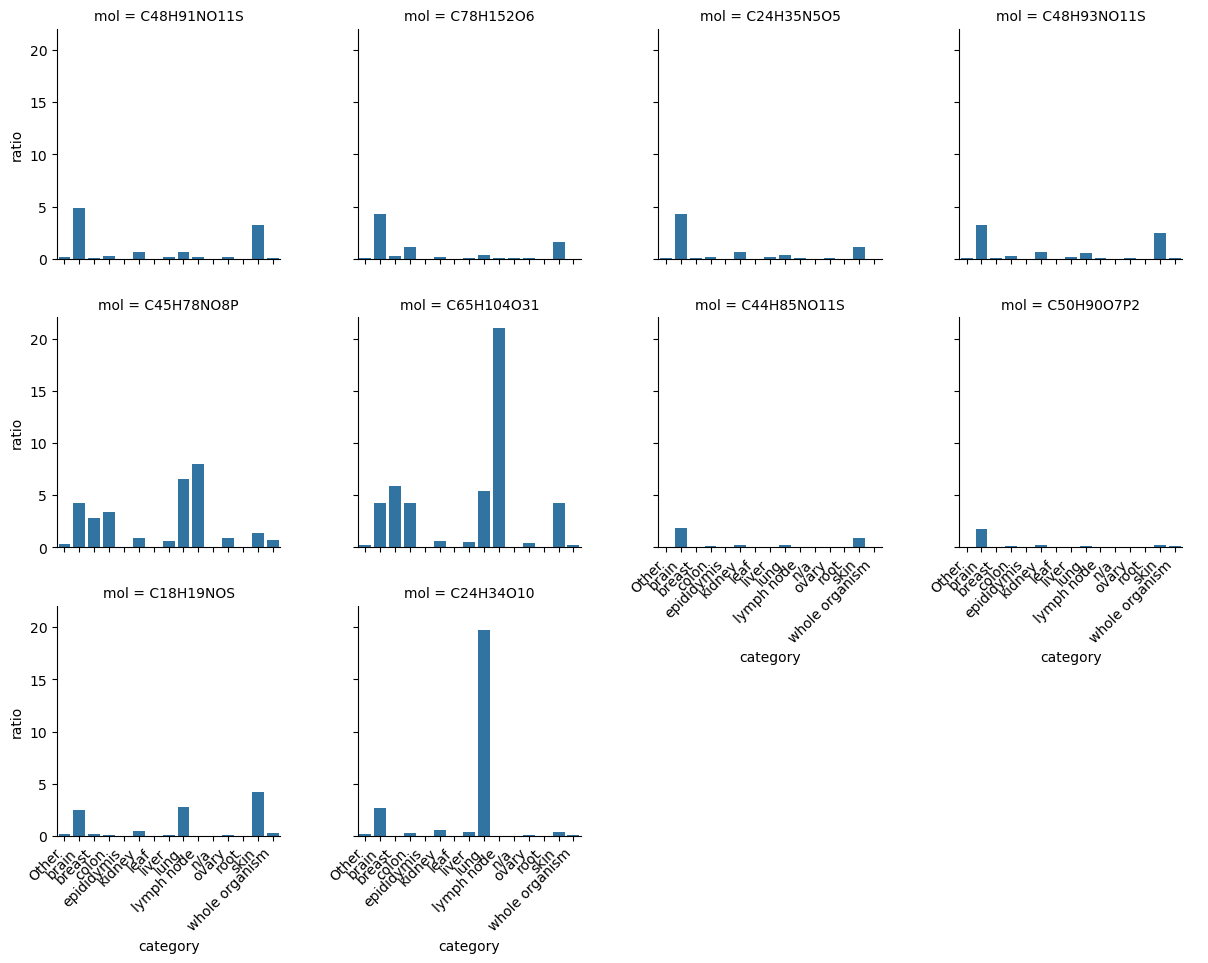

In [151]:
code = 'brain'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Kidney

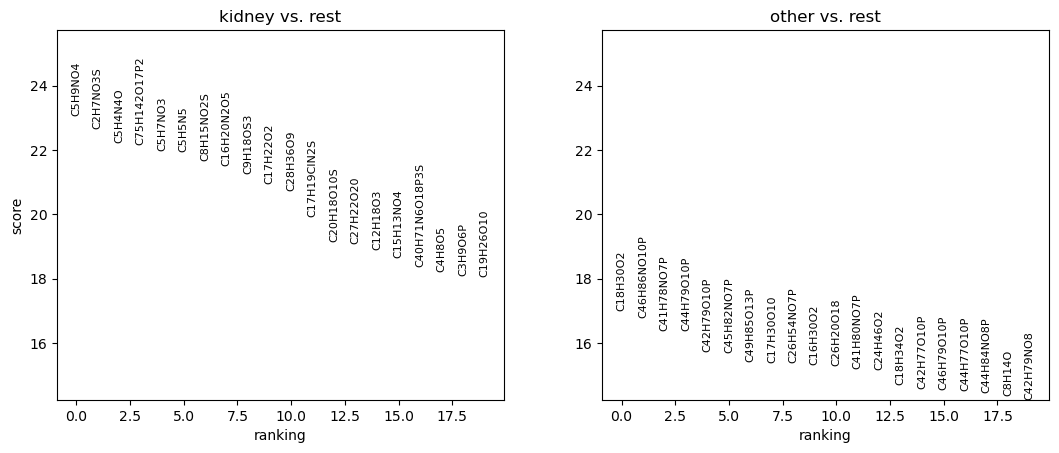

C5H9NO4  -  ['L-Glutamic acid', 'N-Methyl-D-aspartic acid', 'N-Acetylserine', 'O-Acetylserine']
C2H7NO3S  -  ['Taurine']
C5H4N4O  -  ['Hypoxanthine', 'Allopurinol']
C75H142O17P2  -  ['CL(16:0/16:0/16:0/18:2(9Z,12Z))', 'CL(16:0/16:0/16:1(9Z)/18:1(11Z))', 'CL(16:0/16:0/16:1(9Z)/18:1(9Z))', 'CL(16:0/16:0/18:1(11Z)/16:1(9Z))']
C5H7NO3  -  ['Pyroglutamic acid', 'Pyrroline hydroxycarboxylic acid', 'N-Acryloylglycine', '1-Pyrroline-4-hydroxy-2-carboxylate']
C5H5N5  -  ['Adenine']
C8H15NO2S  -  ['S-Prenyl-L-cysteine']
C16H20N2O5  -  ['Formylfusarochromanone']
C9H18OS3  -  ['1-Propenyl 1-(propylsulfinyl)propyl disulfide', '1-(1-Propenylsulfinyl)propyl propyl disulfide', '1-(2-Propenylsulfinyl)propyl propyl disulfide', '2-Propenyl 1-(propylsulfinyl)propyl disulfide']
C17H22O2  -  ['Linalyl benzoate', 'Geranyl benzoate', 'Falcarinolone', 'Ginsenoyne E']
C28H36O9  -  ['Austalide A']
C17H19ClN2S  -  ['Chlorpromazine']
C20H18O10S  -  ['[2,2-dimethyl-6-(3,5,7-trihydroxy-4-oxo-4H-chromen-2-yl)-3,4-dih

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


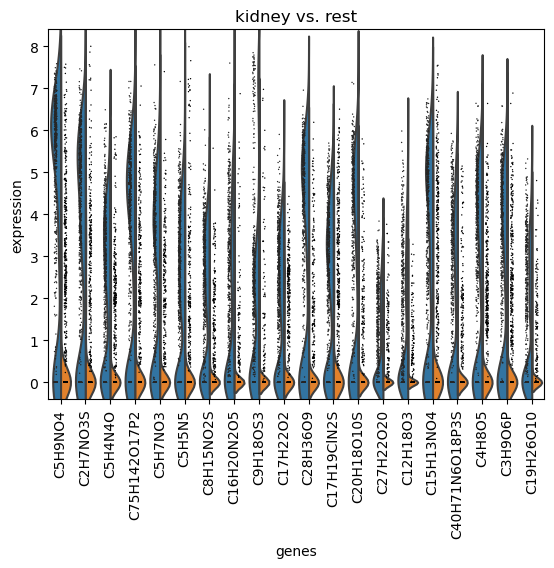

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


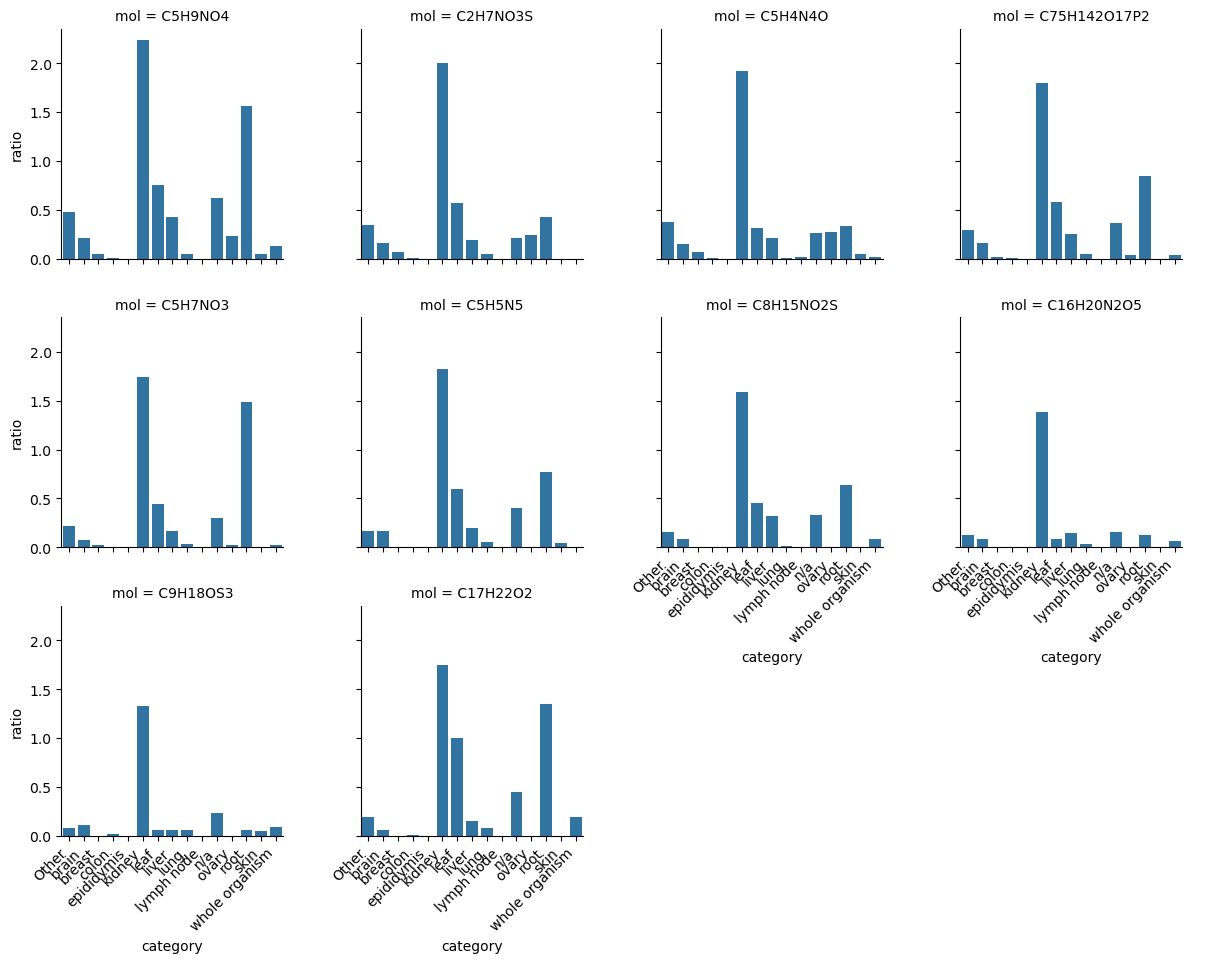

In [152]:
code = 'kidney'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Lung

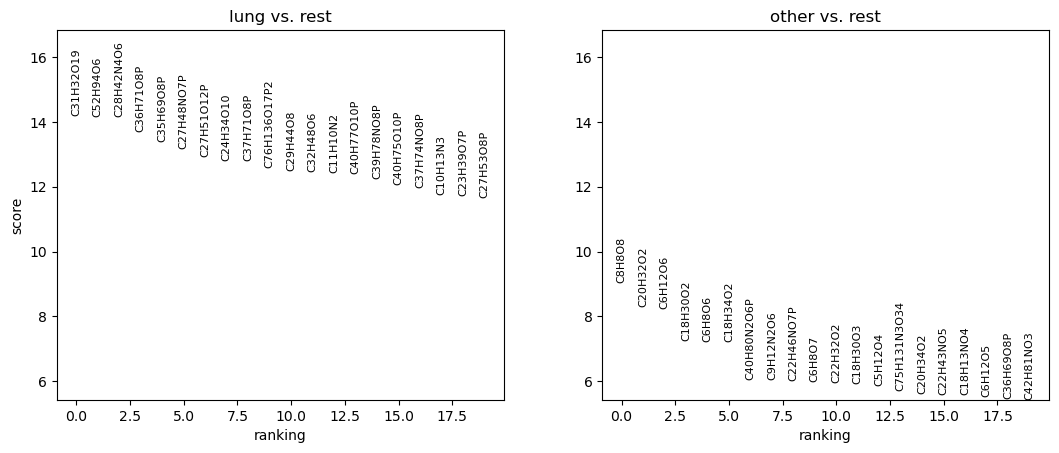

C31H32O19  -  ['6-{1-carboxy-2-oxo-2-[(3,4,5-trihydroxy-6-{[5-hydroxy-3-(4-methoxyphenyl)-4-oxo-4H-chromen-7-yl]oxy}oxan-2-yl)methoxy]ethyl}-3,4,5-trihydroxyoxane-2-carboxylic acid']
C52H94O6  -  ['TG(14:0/15:0/20:3(5Z,8Z,11Z))', 'TG(14:0/15:0/20:3n6)', 'TG(14:0/20:3(5Z,8Z,11Z)/15:0)', 'TG(14:0/20:3n6/15:0)']
C28H42N4O6  -  ['Kukoamine A', 'Kukoamine B', 'Kukoamine C', 'Kukoamine D']
C36H71O8P  -  ['PA(15:0/18:0)', 'PA(18:0/15:0)', 'PA(20:0/13:0)', 'PA(21:0/12:0)']
C35H69O8P  -  ['PA(16:0/16:0)', 'PA(10:0/22:0)', 'PA(18:0/14:0)', 'PA(20:0/12:0)']
C27H48NO7P  -  ['LysoPE(0:0/22:4(7Z,10Z,13Z,16Z))', 'LysoPE(22:4(7Z,10Z,13Z,16Z)/0:0)']
C27H51O12P  -  ['LysoPI(18:1(9Z)/0:0)']
C24H34O10  -  ["3'-Hydroxy-T2 Toxin"]
C37H71O8P  -  ['PA(16:0/18:1(11Z))', 'PA(16:0/18:1(9Z))', '9-Octadecenoic acid 1-[[(1-oxohexadecyl)oxy]methyl]-2-(phosphonoxy)ethyl ester', 'PA(18:0/16:1(9Z))']
C76H136O17P2  -  ['CL(i-13:0/18:2(9Z,11Z)/18:2(9Z,11Z)/18:2(9Z,11Z))', 'CL(a-13:0/18:2(9Z,11Z)/18:2(9Z,11Z)/18:2(9Z,11Z)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


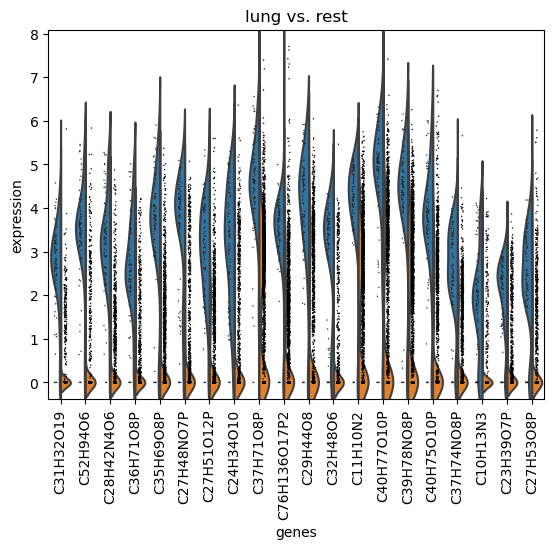

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


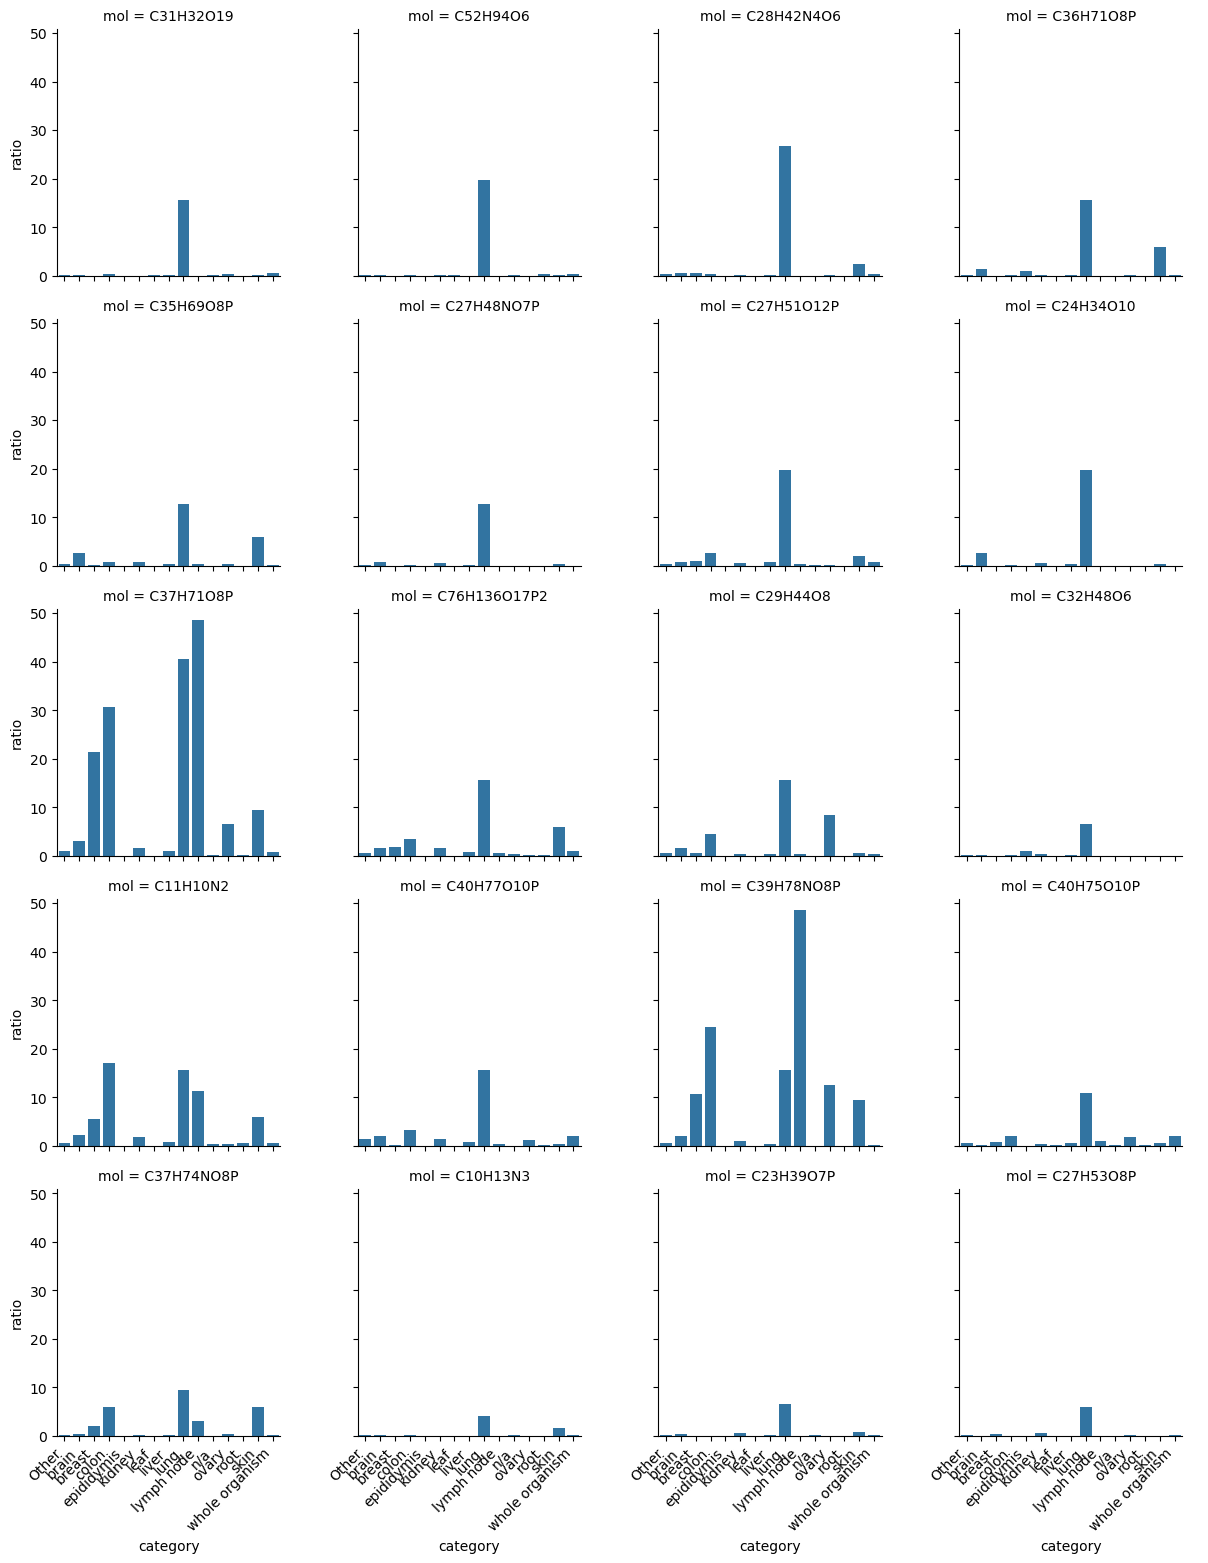

In [167]:
code = 'lung'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=20, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=20)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


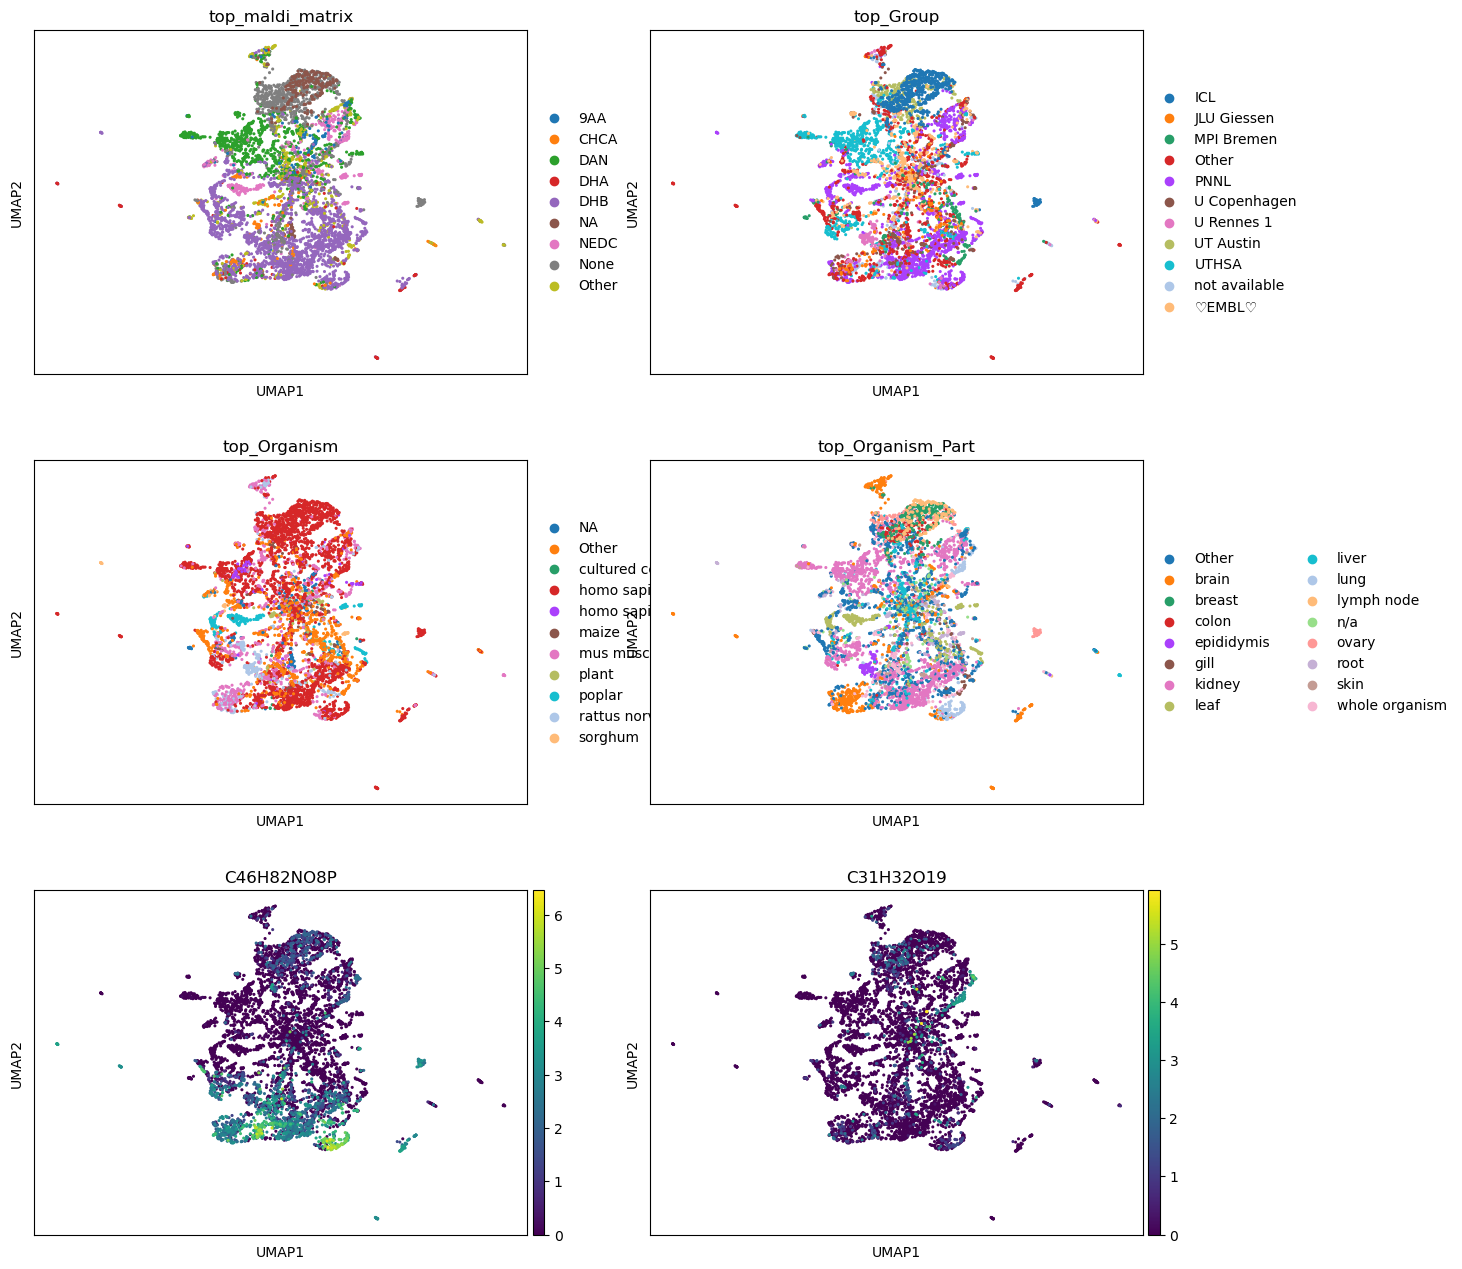

In [169]:
sc.pl.umap(adata, color=['top_maldi_matrix', 'top_Group', 
                             'top_Organism', 'top_Organism_Part', 'C46H82NO8P', 'C31H32O19'], 
           ncols=2)


### Liver

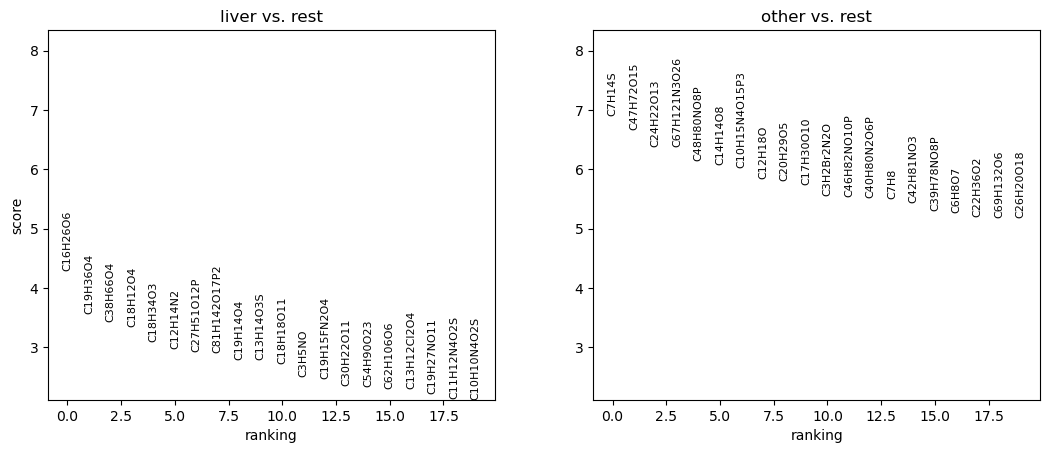

C16H26O6  -  ['(-)-trans-Carveol glucoside', '(+)-trans-Carveol glucoside', 'Perilloside A']
C19H36O4  -  ['MG(0:0/16:1(9Z)/0:0)', 'MG(16:1(9Z)/0:0/0:0)', 'Avocadene 1-acetate', 'Avocadene 2-acetate']
C38H66O4  -  ['Erythrinasinate A']
C18H12O4  -  ['3-Hydroxy-9-(4-hydroxyphenyl)-1H,3H-naphtho[1,8-cd]pyran-1-one', '3-Hydroxy-4-(4-hydroxyphenyl)-1H,3H-naphtho[1,8-cd]pyran-1-one']
C18H34O3  -  ['3-Oxooctadecanoic acid', '9-Oxooctadecanoic acid', '10-Oxooctadecanoic acid', '11-Oxooctadecanoic acid']
C12H14N2  -  ['1,2,3,4-Tetrahydro-2-methyl-b-carboline', '1-Phenyl-5-propyl-1H-pyrazole', 'Detomidine']
C27H51O12P  -  ['LysoPI(18:1(9Z)/0:0)']
C81H142O17P2  -  ['CL(18:2(9Z,12Z)/18:2(9Z,12Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'CL(16:0/16:0/18:2(9Z,12Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'CL(16:0/16:0/20:4(5Z,8Z,11Z,14Z)/20:4(5Z,8Z,11Z,14Z))', 'CL(16:0/16:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z))']
C19H14O4  -  ['2,3-Dihydro-2,3-dihydroxy-4-(4-hydroxyphenyl)-1H-phenalen-1-one', 'Musanolone C', 'Dehydr

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


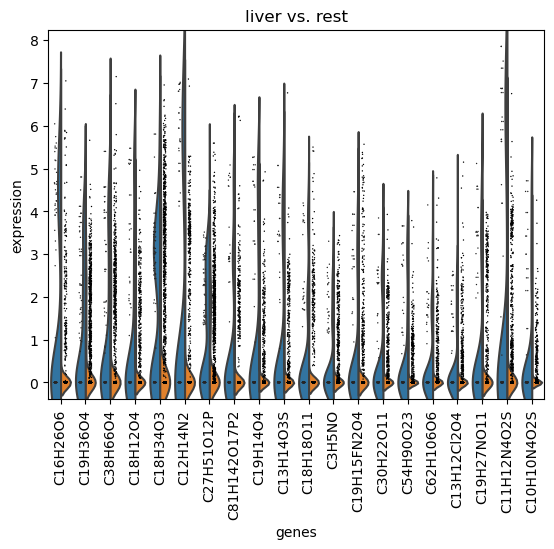

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


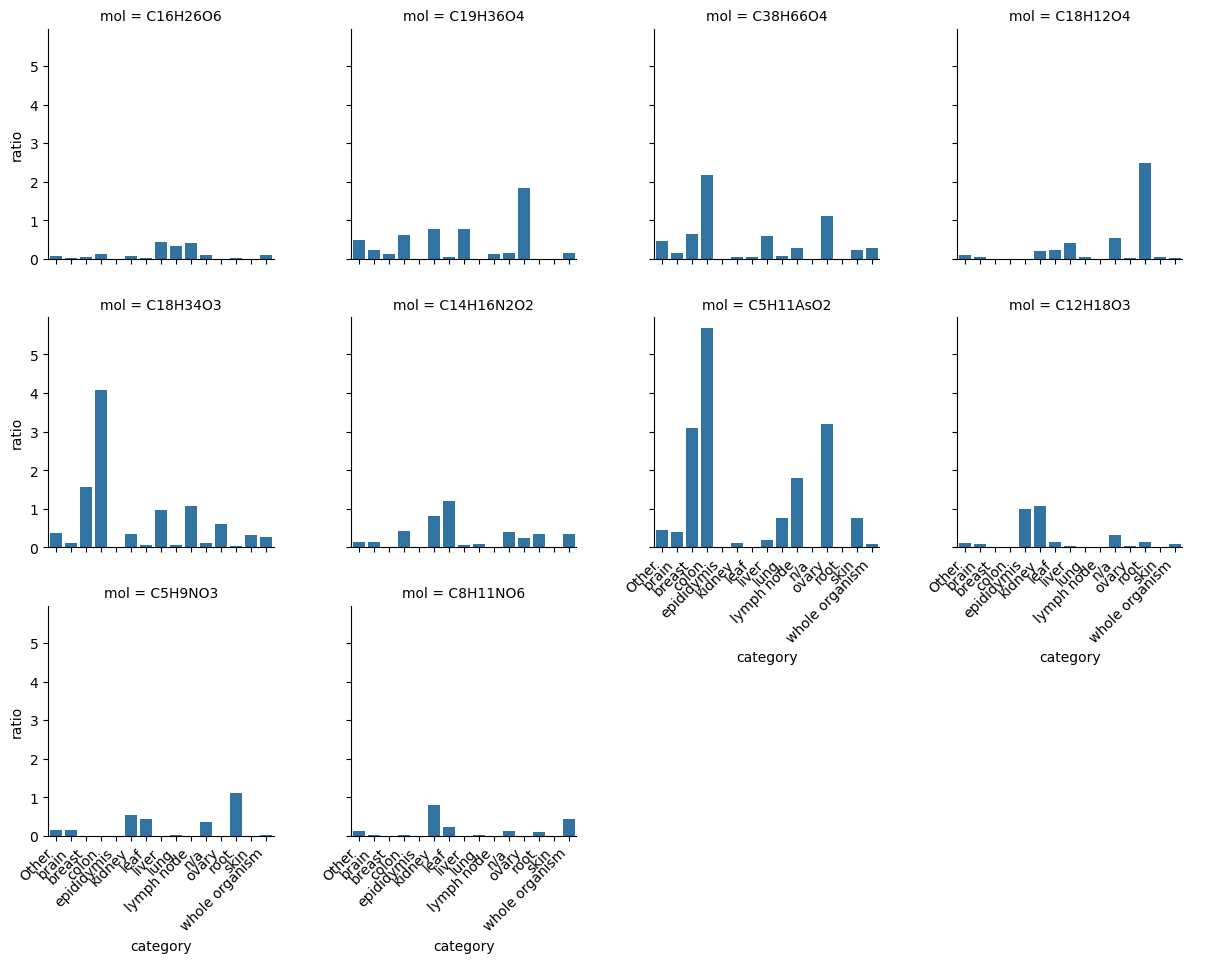

In [154]:
code = 'liver'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Leaf

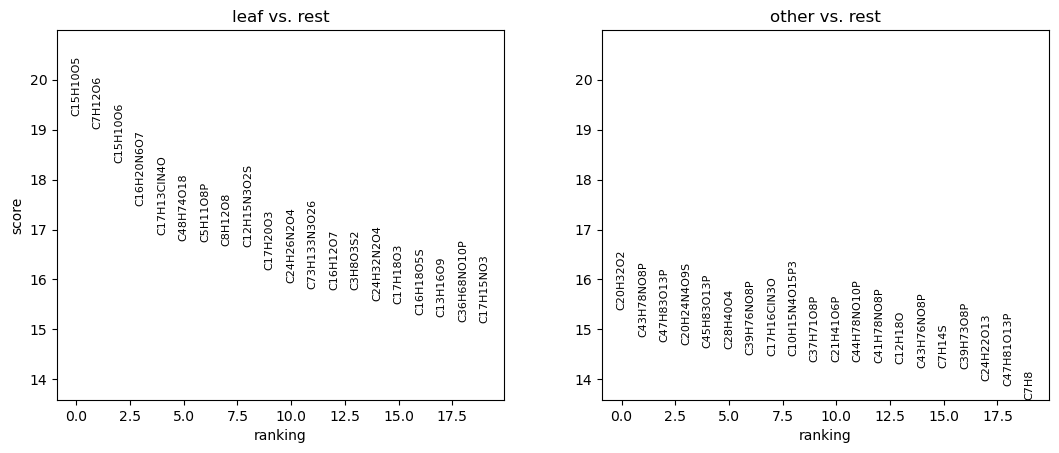

C15H10O5  -  ['Apigenin', 'Genistein', "2'-Hydroxydaidzein", 'Norizalpinin']
C7H12O6  -  ['Quinic acid']
C15H10O6  -  ['Luteolin', 'Kaempferol', 'Maritimetin', 'Norartocarpetin']
C16H20N6O7  -  ['Wybutoxine']
C17H13ClN4O  -  ['Alpha-hydroxyalprazolam', '4-hydroxyalprazolam']
C48H74O18  -  ['AzI']
C5H11O8P  -  ['D-Ribulose 5-phosphate', 'Xylulose 5-phosphate', 'Ribose 1-phosphate', 'D-Ribose 5-phosphate']
C8H12O8  -  ['6-(acetyloxy)-3,4,5-trihydroxyoxane-2-carboxylic acid', '3,4,5-trihydroxy-6-(2-oxoethoxy)oxane-2-carboxylic acid']
C12H15N3O2S  -  ['Albendazole']
C17H20O3  -  ['(S)-Verimol F']
C24H26N2O4  -  ['Carvedilol']
C73H133N3O26  -  ['Ganglioside GM2 (d18:1/24:0)']
C16H12O7  -  ['Isorhamnetin', "3,4',5,7-Tetrahydroxy-6-methoxyflavone", '2-(3,4-Dihydroxyphenyl)-5,6-dihydroxy-7-methoxy-4H-1-benzopyran-4-one', 'Pollenitin']
C3H8O3S2  -  ['S-Propyl thiosulfate']
C24H32N2O4  -  ['Trandolapril-d5 Diketopiperazine']


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


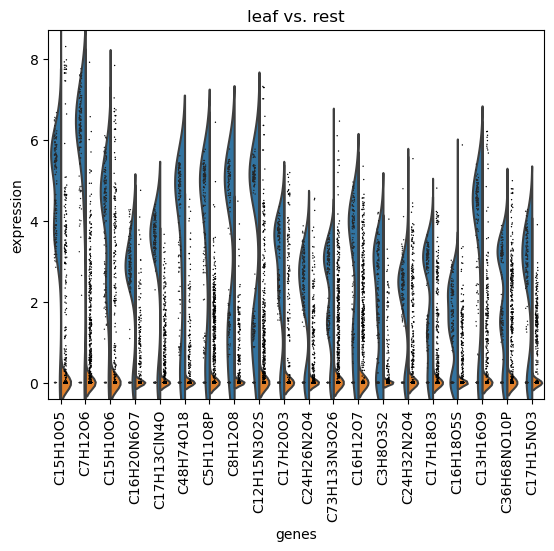

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


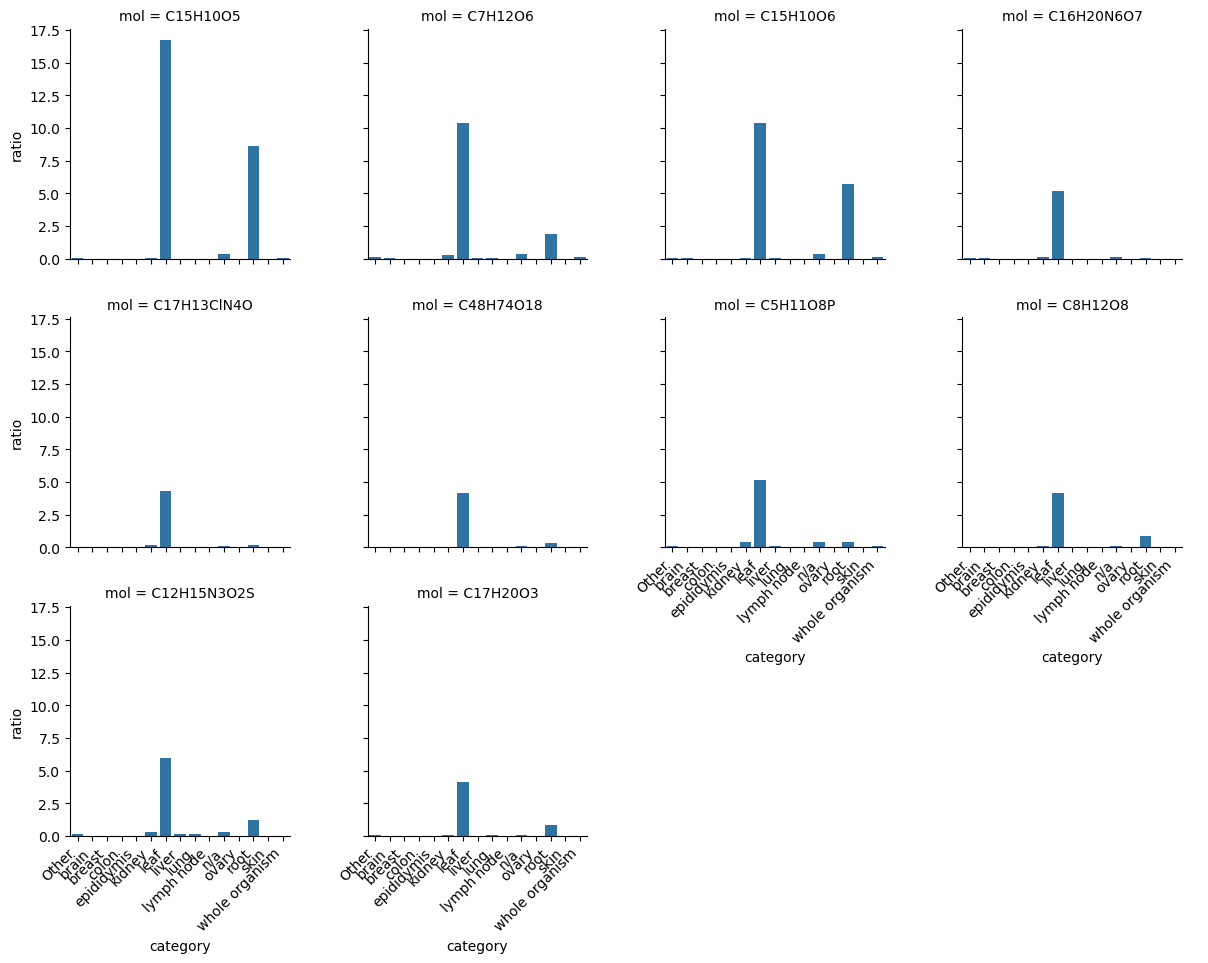

In [155]:
code = 'leaf'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Colon

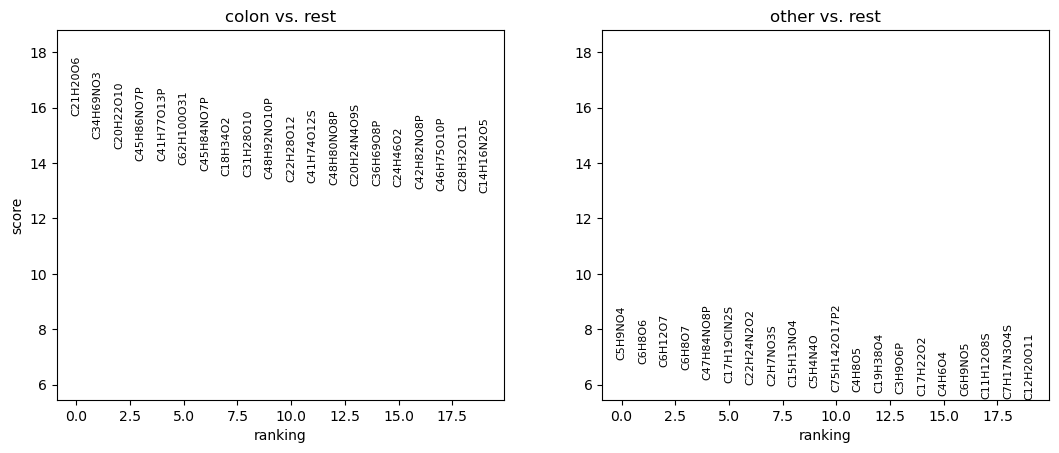

C21H20O6  -  ['Curcumin', 'Integrin', 'Artocarpetin A', 'Cyclointegrin']
C34H69NO3  -  ['Cer(d18:0/16:0)']
C20H22O10  -  ['Rumexoside', '3,4,5-trihydroxy-6-{[8-hydroxy-6-(3-methylbut-2-en-1-yl)-2-oxo-2H-chromen-7-yl]oxy}oxane-2-carboxylic acid', '3,4,5-trihydroxy-6-{[7-hydroxy-6-(3-methylbut-2-en-1-yl)-2-oxo-2H-chromen-8-yl]oxy}oxane-2-carboxylic acid', '3,4,5-trihydroxy-6-{[4-(7-methoxy-2-oxo-2H-chromen-6-yl)but-3-en-2-yl]oxy}oxane-2-carboxylic acid']
C45H86NO7P  -  ['PE(22:1(13Z)/P-18:1(11Z))', 'PE(22:1(13Z)/P-18:1(9Z))', 'PE(22:2(13Z,16Z)/P-18:0)', 'PE(P-18:0/22:2(13Z,16Z))']
C41H77O13P  -  ['PI(16:0/16:1(9Z))', 'PI(16:1(9Z)/16:0)']
C62H100O31  -  ['Agavasaponin E']
C45H84NO7P  -  ['PE(22:2(13Z,16Z)/P-18:1(11Z))', 'PE(22:2(13Z,16Z)/P-18:1(9Z))', 'PE(P-18:1(11Z)/22:2(13Z,16Z))', 'PE(P-18:1(9Z)/22:2(13Z,16Z))']
C18H34O2  -  ['Oleic acid', 'Elaidic acid', 'Petroselinic acid', 'Vaccenic acid']
C31H28O10  -  ['8-[3,7-dihydroxy-2-(3-hydroxyphenyl)-3,4-dihydro-2H-1-benzopyran-4-yl]-2-(4-hy

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


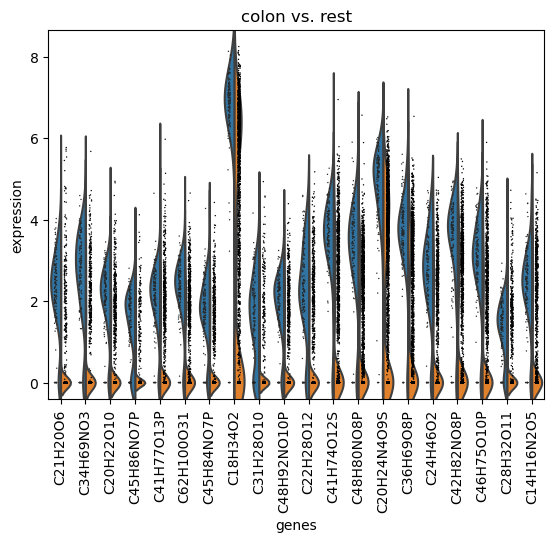

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


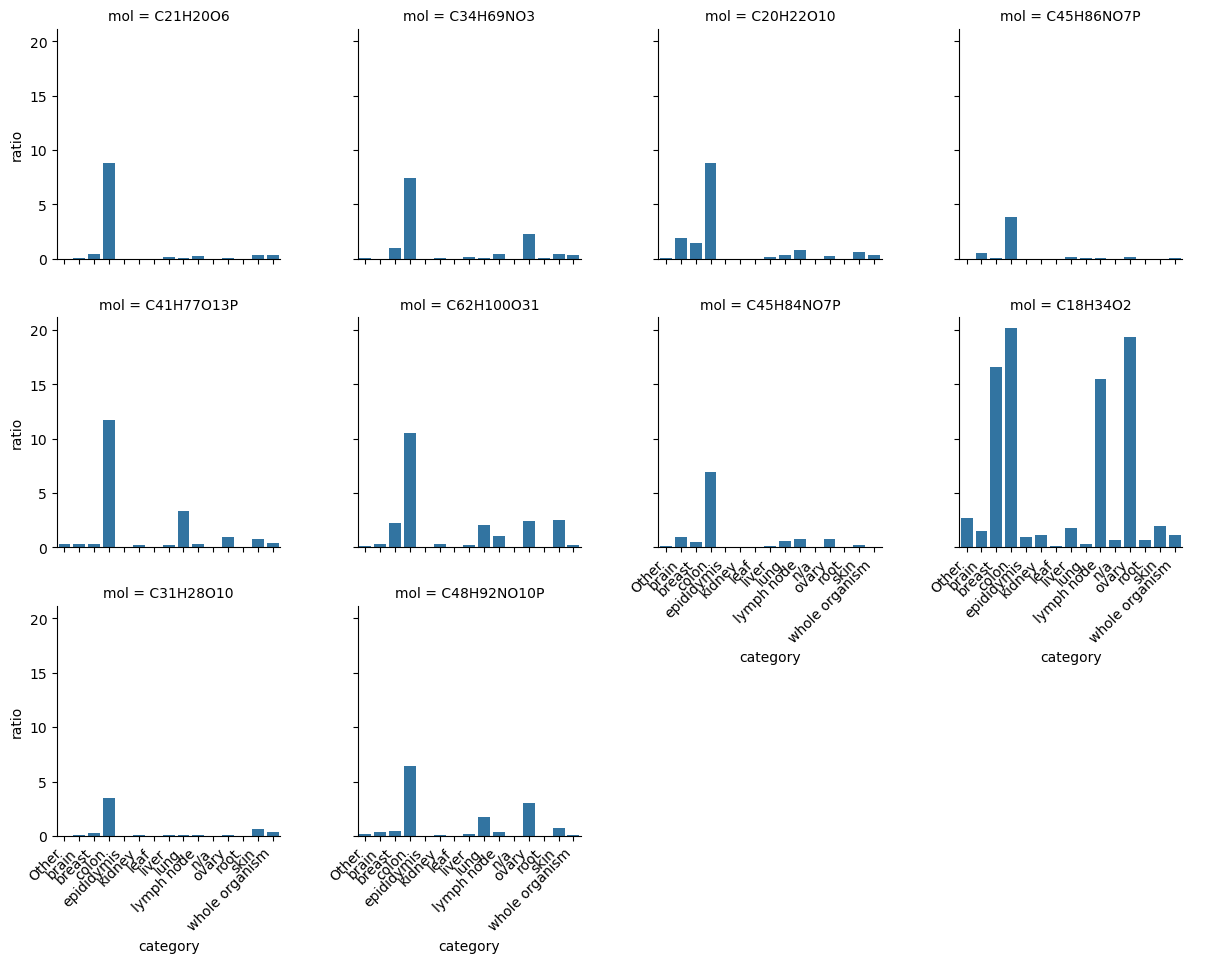

In [156]:
code = 'colon'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=code)

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

### Ovary

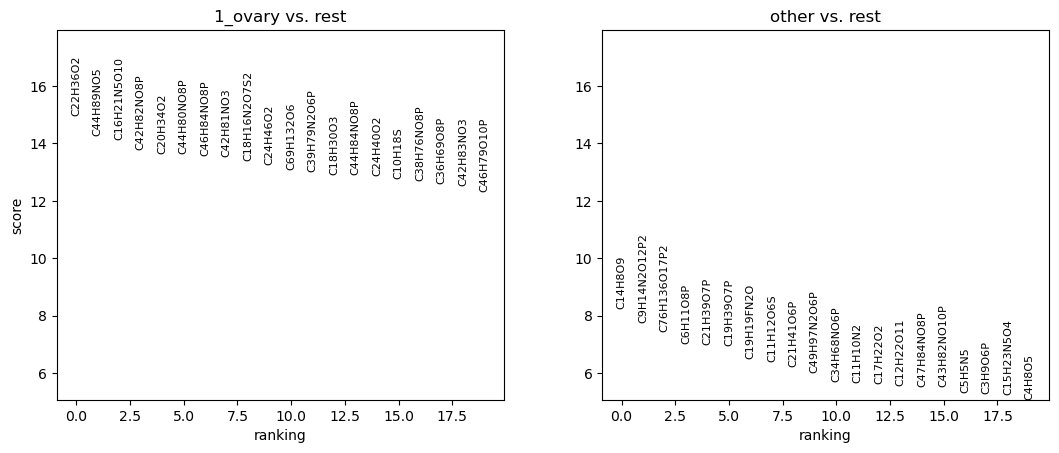

C22H36O2  -  ['Adrenic acid', '1-Hydroxy-1-phenyl-3-hexadecanone', '3-Hydroxy-1-phenyl-1-hexadecanone', '2-Methyl-5-(8-pentadecenyl)-1,3-benzenediol']
C44H89NO5  -  ['N-(2R-Hydroxyhexacosanoyl)-2S-amino-1,3S,4R-octadecanetriol']
C16H21N5O10  -  ["3'-Azido-3'-deoxy-5'- O-beta-D-glucopyranuronosylthymidine"]
C42H82NO8P  -  ['PC(14:0/20:1(11Z))', 'PC(14:1(9Z)/20:0)', 'PC(16:0/18:1(11Z))', 'PC(16:0/18:1(9Z))']
C20H34O2  -  ['Dihomo-gamma-linolenic acid', '5,8,11-Eicosatrienoic acid', 'Sciadonic acid', 'Sagittariol']
C44H80NO8P  -  ['PC(14:0/22:4(7Z,10Z,13Z,16Z))', 'PC(16:0/20:4(5Z,8Z,11Z,14Z))', 'PC(16:0/20:4(8Z,11Z,14Z,17Z))', 'PC(16:1(9Z)/20:3(5Z,8Z,11Z))']
C46H84NO8P  -  ['PC(16:0/22:4(7Z,10Z,13Z,16Z))', 'PC(18:0/20:4(5Z,8Z,11Z,14Z))', 'PC(18:0/20:4(8Z,11Z,14Z,17Z))', 'PC(18:1(11Z)/20:3(5Z,8Z,11Z))']
C42H81NO3  -  ['Cer(d18:1/24:1(15Z))']
C18H16N2O7S2  -  ['C.I. Food Red 1']
C24H46O2  -  ['Nervonic acid', '(E)-2-Tetracosenoic acid', '10,12-Tetracosanedione', '7,9-Tetracosanedione']
C69H

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


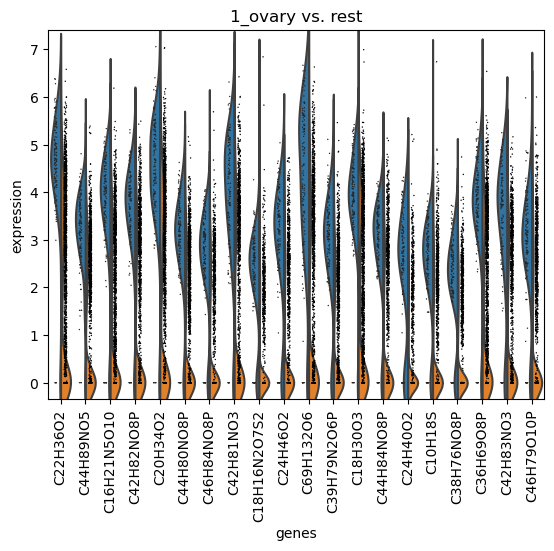

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


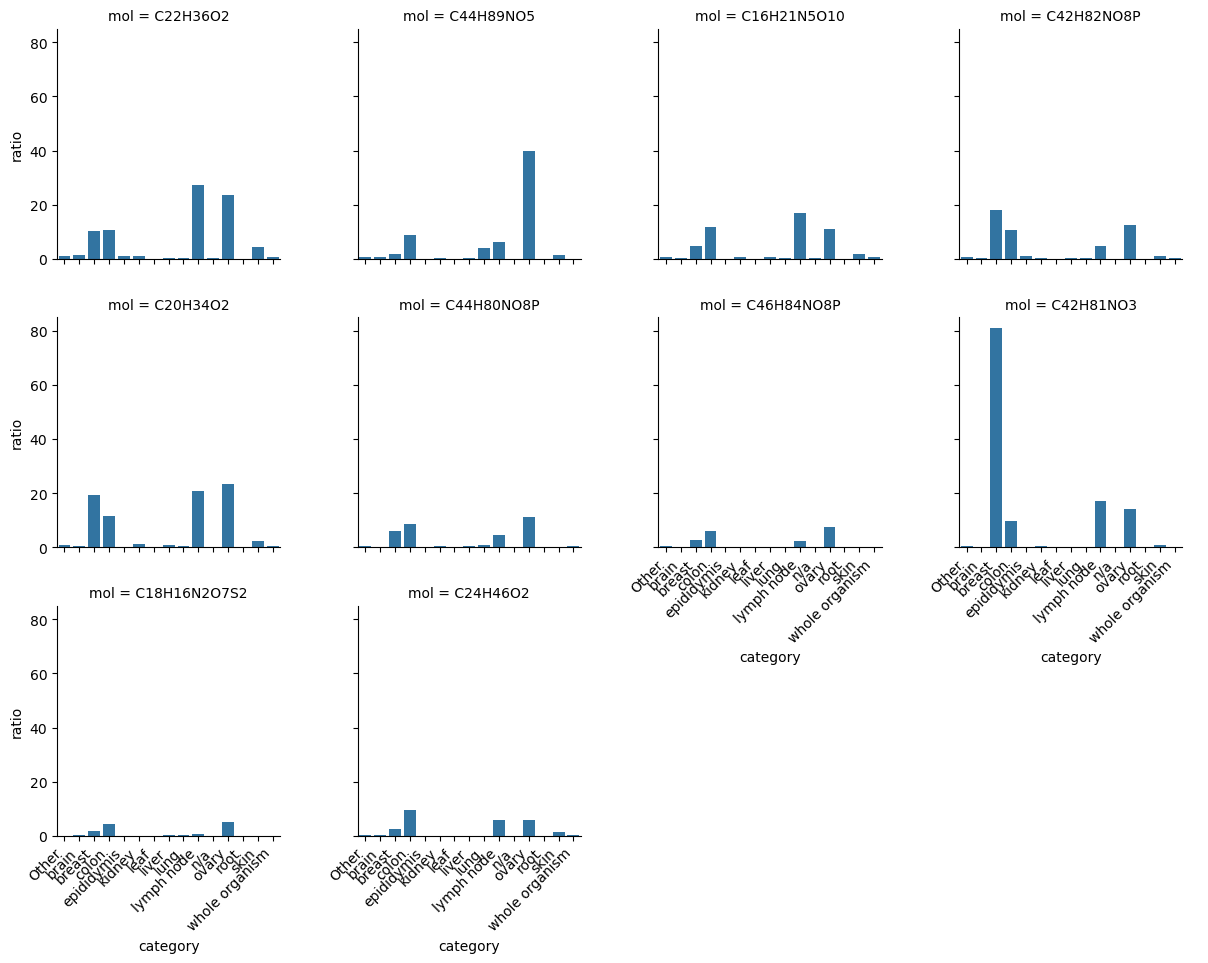

In [158]:
code = 'ovary'
adat = adata_neg

sc.pl.rank_genes_groups(adat, key=f'ranked_genes_{code}')

utils.top_annotations(adat.uns[f'ranked_genes_{code}']['names'], hmdb_v4, top=15, n=4, is_ion=True)
sc.pl.rank_genes_groups_violin(adat, key=f'ranked_genes_{code}', groups=f'1_{code}')

tst = utils.get_sig_molecules(adat, rg=f'ranked_genes_{code}', max_mols=10)
ratios = utils.identifications(adat, tst, 'top_Organism_Part')

g = sns.FacetGrid(ratios, col = 'mol', col_wrap=4)
g = (g.map(sns.barplot, 'category', 'ratio').add_legend())

tmp = g.axes[-1].get_xticklabels()
for x in range(len(g.axes)):
    g.axes[x].set_xticklabels(tmp, rotation=45, ha='right')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


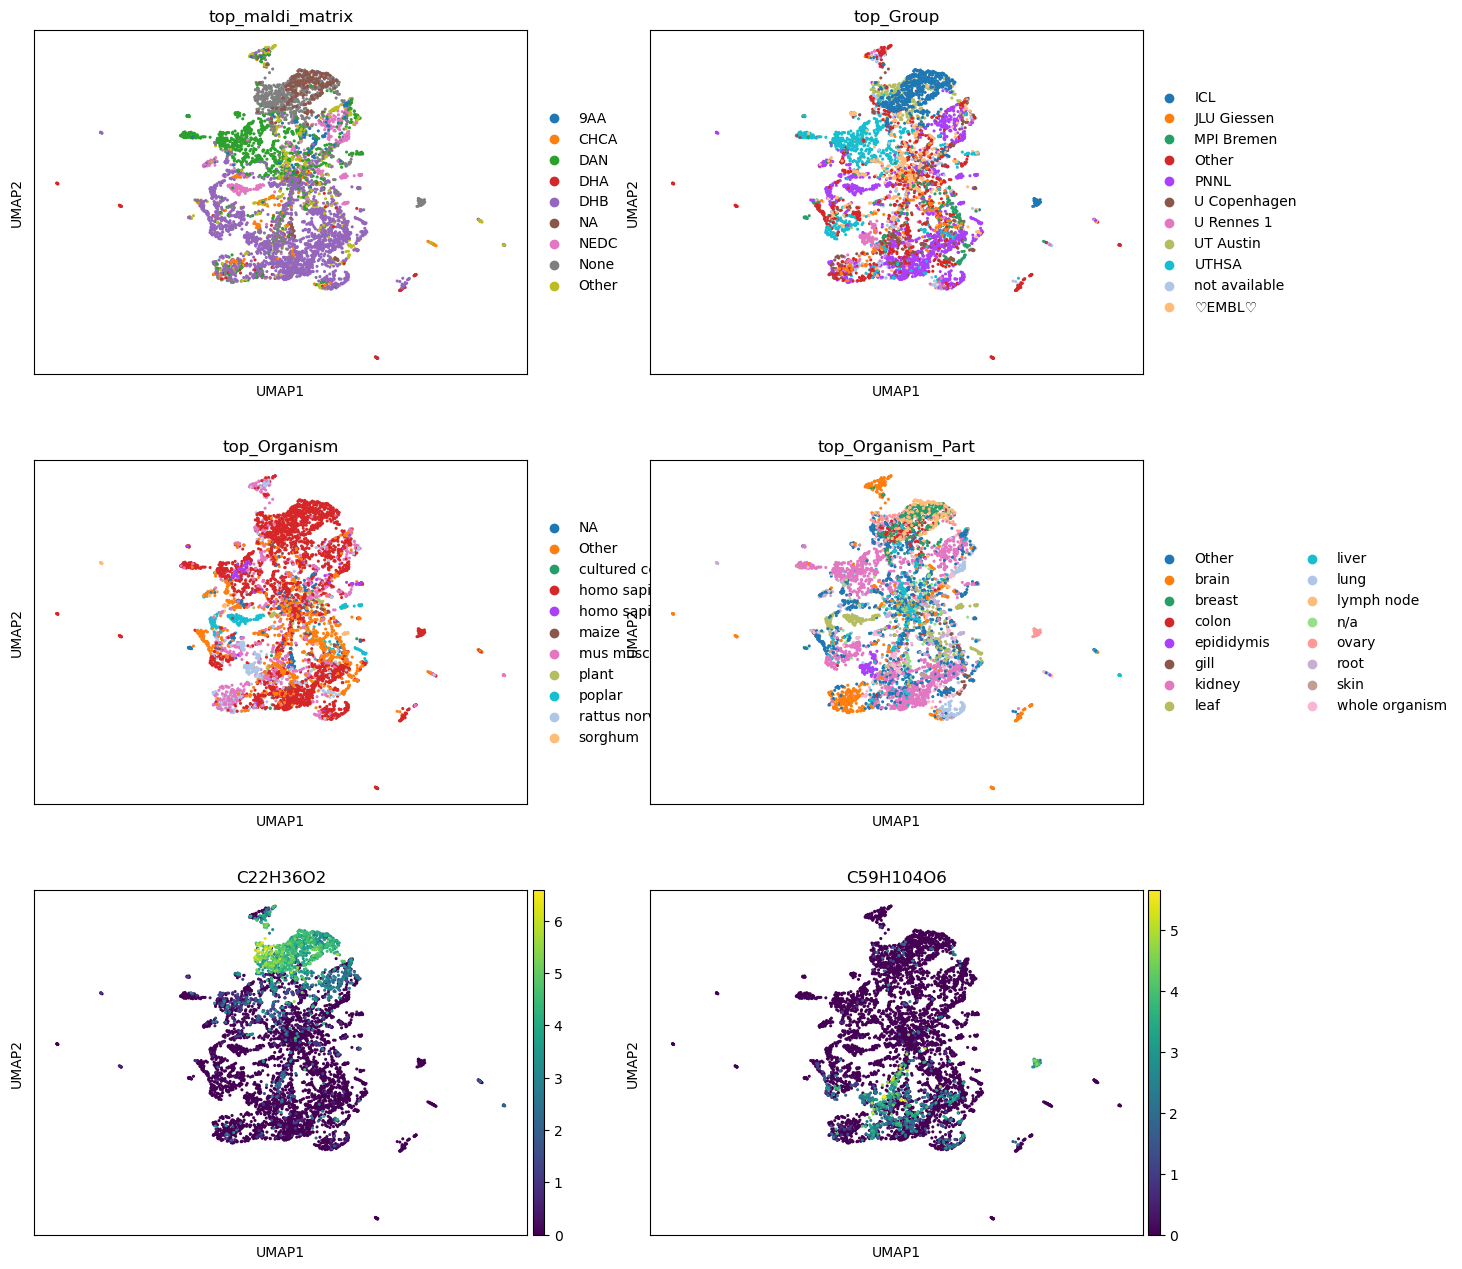

In [170]:
sc.pl.umap(adata, color=['top_maldi_matrix', 'top_Group', 
                             'top_Organism', 'top_Organism_Part', 'C22H36O2', 'C59H104O6'], 
           ncols=2)
